> **Submission Deadline: 07.06.2025 - 23:55**
>
> -   Your homework solution has to be handed in as a group solution via
>     Moodle.
> -   Your notebooks must run without errors in our environment on the
>     RWTH-Cluster. See
>     [here](https://mbd.pages.rwth-aachen.de/courses/cmm/content/wiki/how_to_homework.html)
>     for more information on how to get started.

> **Participant list**
>
> Please add your names and student ID (Matrikelnummer) here:
>
> 1.  Phuong-Nam Nguyen, 463920
> 2.  Zeyad Ibrahim, 464432
> 3.  Sebastian Linden, 409559
> 4.  Christopher Gomez, 464848

# Learning goals

1.  Understand the basic structure of a mixed finite element method for
    the (Navier-)Stokes equations
2.  Understand the relationship between the Navier-Stokes and the Stokes
    equations
3.  Investigate the influence of the Reynolds number

> **Before you start**
>
> 1.  Make sure that you update the `library` folder in your `CMM`
>     directory. Download link:
>     [library.tar.gz](https://mbd.pages.rwth-aachen.de/courses/cmm/content/exercises/notebooks/library.tar.gz)  
> 2.  Make sure that you update your `dolfinx_latest.sif` container
>     image.
>
> You can use the following command on the RWTH cluster/Linux:
>
>         wget https://mbd.pages.rwth-aachen.de/courses/cmm/content/exercises/notebooks/homework03.out.ipynb
>         rm -rf library
>         wget https://mbd.pages.rwth-aachen.de/courses/cmm/content/exercises/notebooks/library.tar.gz
>         tar -xvzf library.tar.gz
>         rm library.tar.gz
>         rm dolfinx_latest.sif
>         apptainer pull oras://registry.git.rwth-aachen.de/mbd/courses/containers/dolfinx:latest

> **Batch job execution**
>
> To run the notebook on the backend of the HPC Cluster, run
>
>     sbatch < library/batch_hw03.sh
>
> To query the current status of your batch job, prompt
>
>     squeue --me
>
> This will also show you the status (`ST`) of your job. If it is `R`,
> it is running, if it is `PD`, it is pending / waiting for resources.

# Todo’s:

Make sure that all tests in the notebook run without errors. The
following tasks need to be completed:

-   [ ] Update the participant list
-   [ ] implement the analytical solution for the Couette flow between
    two plates
-   [ ] Cylinder Problem 1: Implement the convection term for the
    iterative nonlinear solver
-   [ ] Cylinder Problem 1: Set the right inflow velocity for a Reynolds
    number of 20
-   [ ] Cylinder Problem 2: Implement the time discretization for the
    transient term
-   [ ] Cylinder Problem 2: Set the right inflow velocity for a Reynolds
    number of 100
-   [ ] Cylinder Problem 2: Run the notebook as a batch job to simulate
    a Vortex street and compare with the reference results.

# Imports

In [1]:
import os
import sys
import numpy as np

from mpi4py import MPI
import pyvista
import tqdm.autonotebook

import dolfinx.plot
from  dolfinx.fem import petsc
from petsc4py import PETSc
import ufl
from basix.ufl import element, mixed_element
from dolfinx import default_real_type, fem, la

from dolfinx.fem import (
    Constant,
    Function,
    dirichletbc,
    extract_function_spaces,
    form,
    functionspace,
    locate_dofs_topological,
)

from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
from dolfinx.io import XDMFFile, VTXWriter
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import div, dx, grad, inner

import library.plot
import library.helpers
import library.boundary 

CMM_DIR = os.getcwd()
os.environ["PYTHONPATH"] = f"{CMM_DIR}:{os.environ.get('PYTHONPATH', '')}"

# overload print function to print only on rank 0
def print_rank0(*args, **kwargs):
    if MPI.COMM_WORLD.rank == 0:
        print(*args, **kwargs)

output_dir = ""
if MPI.COMM_WORLD.rank == 0:
    output_dir = library.helpers.make_unique_dir(os.path.join(CMM_DIR, 'results_ex_03'))

# mpi share output_dir to all ranks
output_dir = MPI.COMM_WORLD.bcast(output_dir, root=0)

# Check if we are running interactively (e.g. Jupyter notebook with visual frontend)
# or as a script: https://stackoverflow.com/a/64523765
interactive_mode_is_on = hasattr(sys, 'ps1')

if os.getenv('DEVCONTAINER') and interactive_mode_is_on:
    pyvista.start_xvfb()

# Mixed finite elements for the steady Stokes model

We start with the Stokes model, which is a special case of the
Navier-Stokes equations. The Stokes equations are given by 
$$
\begin{aligned}
\nabla \cdot \sigma(\mathbf{u}, p) + \mathbf{f} &= 0 \quad \text{in } \Omega, \\
\nabla \cdot \mathbf{u} &= 0 \quad \text{in } \Omega,
\end{aligned}
$$ where $\sigma(\mathbf{u}, p) = 2 \, \mu \, \varepsilon(u) - p I$ is
the stress tensor,
$\varepsilon(\mathbf{u}) = \frac{1}{2} (\nabla \mathbf{u} + \nabla \mathbf{u}^T)$
is the strain tensor assuming a Newtonian fluid, $\mathbf{u}$ is the
velocity field, $p$ is the pressure, $\mu$ is the dynamic viscosity, and
$f$ is a given body force.

By inserting $\sigma$ into the first equation and using the
incompressibility condition $\nabla \cdot u = 0$, we can rewrite the
Stokes equations as

$$
\begin{aligned}
\mu \, \Delta \mathbf{u} - \nabla p  + \mathbf{f} &= 0 \quad \text{in } \Omega, \\
\nabla \cdot \mathbf{u} &= 0 \quad \text{in } \Omega.
\end{aligned}
$$

with boundary conditions

$$
\begin{aligned}
\mathbf{u} &= \mathbf{u}_D \quad  & \text{on } \Gamma_D, \\
\boldsymbol{\nabla}\mathbf{u}\cdot\mathbf{n} - p\,\mathbf{n}  &= \mathbf{g} \quad & \text{on } \Gamma_N,
\end{aligned}
$$

where $\mathbf{u}_D$ is the velocity on the Dirichlet boundary
$\Gamma_D$, $\mathbf{g}$ is the natural boundary condition, and
$\mathbf{n}$ is the outward unit normal.

We aim to discretize the equations using mixed finite elements, where
“mixed” refers to the fact that the velocity and pressure are
approximated by different finite element spaces.

## The weak formulation

The weak formulation is the main building block of any finite element
discretization.

Due to the different possibilities to integrate terms by parts the weak
formulation is not unique and different formulations can result in
linear systems with different structure and properties.

Here, we consider the following weak formulation of the Stokes
equations: Find $(\mathbf{u}, p) \in \mathbb{V} \times \mathbb{Q}$ such
that

$$
\begin{aligned}
\int_{\Omega} \mu \, \nabla \mathbf{u} : \nabla \mathbf{v} \, \text{d}x - \int_{\Omega} p \, \nabla \cdot \mathbf{v} \, \text{d}x  &= \int_{\Omega} \mathbf{f} \cdot \mathbf{v} \, \text{d}x + \int_{\Gamma^N} \mathbf{g} \cdot \mathbf{v} \, \text{d}S \quad \forall \, \mathbf{v} \in \mathbb{V}, \\
\int_{\Omega} \nabla \cdot \mathbf{u} \, q \, \text{d}x &= 0 \quad \forall \, q \in \mathbb{Q}.
\end{aligned}
$$

which can be written as

$$
\begin{aligned}
a(\mathbf{u}, \mathbf{v}) + b(\mathbf{v}, p) &= L(\mathbf{v}) \quad \forall \, \mathbf{v} \in \mathbb{V}, \\
b(\mathbf{u}, q) &= 0 \quad \forall \, q \in \mathbb{Q} \\
\end{aligned}
$$

with

$$
\begin{aligned}
a \,:\, \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}\,, \quad & a(\mathbf{u}, \mathbf{v}) = \int_{\Omega} \mu \, \nabla \mathbf{u} : \nabla \mathbf{v} \, \text{d}x  \\
b \,:\, \mathbb{R}^d \times \mathbb{R} \to \mathbb{R}\,, \quad & b(\mathbf{u}, q) = -\int_{\Omega} \nabla \cdot \mathbf{u} \, q \, \text{d}x, \\
L \,:\, \mathbb{R}^d \to \mathbb{R}\,, \quad & L(\mathbf{v}) = \int_{\Omega} \mathbf{f} \cdot \mathbf{v} \, \text{d}x + \int_{\Gamma^N} \mathbf{g} \cdot \mathbf{v} \,\text{d}S.
\end{aligned}
$$

Note that we assume zero natural boundary conditions on $\Gamma^N$ for
the sake of simplicity. One important thing to realize is that the exact
definition of $\mathbf{g}$ depends on how the weak form is derived. In
particular there is two approaches:

1.  Apply integration by parts to the general Stokes equation written
    with the general stress tensor entering through
    $\boldsymbol{\nabla} \cdot \boldsymbol{\sigma}$ (fist equation).
2.  Make use of the incompressibility condition to realize that
    $\boldsymbol{\nabla} \cdot \boldsymbol{\sigma}$ is equal to
    $-\boldsymbol{\nabla} p + \mu \Delta \mathbf{u}$ for a Newtonian
    fluid. Then this “Laplace” form of the Stokes equations is
    integrated by parts to obtain the weak form.

Depending on the “route” to the weak form, the natural boundary
condition $\mathbf{g}$ will have a different interpretation and hence
the physical interpretation of what it means to assume
$\mathbf{g} \equiv 0$ is different. Further discussion of this is beyond
the scope of this exercise but you can find a summary of the discussion
[here](https://scicomp.stackexchange.com/questions/8166/finite-elements-for-stokes-with-traction-boundary-conditions).

Note that we flipped the sign of $b(\mathbf{u}, q)$ to obtain preserve a
symmetric block matrix structure, which is possible because the
continuity equation holds true regardless of the sign in front of the
divergence.

## Solving the mixed Stokes problem with FenicsX

In the following sections, we move from math to code and implement the
weak form of the Stokes equations in FenicsX.

## Our first flow problem: Steady couette flow between two parallel plates

In the first example, we consider a [Couette
flow](https://en.wikipedia.org/wiki/Couette_flow), in a channel
$\Omega = [0, 2] \times [0, 1]$ at constant pressure.

In this problem setup, the flow is driven by constant motion of the
upper plate, while the lower plate is stationary.

## The discrete computational domain

We start by creating a discrete approximation of the computational
domain $\Omega$. Here we use triangular elements to discretize the
domain.

In [ ]:
mesh = create_rectangle(
    MPI.COMM_WORLD, [np.array([0, 0]), np.array([2, 1])], [64, 32], CellType.triangle # default: [32, 32]
)

Let’s have a quick look at the mesh:

In [ ]:
def show_mesh():
    """ 
    Show mesh in interactive mode to get an idea of the domain. 
    """

    if interactive_mode_is_on:
        print_rank0("Show mesh...")
        # Extract topology from mesh and create pyvista mesh
        topology, cell_types, x = dolfinx.plot.vtk_mesh(mesh)
        grid = pyvista.UnstructuredGrid(topology, cell_types, x)

        plotter = pyvista.Plotter()
        plotter.add_mesh(grid, show_edges=True)
        plotter.camera_position = "xy"
        # Set the default window size globally
        pyvista.global_theme.window_size = (800, 600)  # Adjust width and height as needed
        plotter.show()

Show mesh...


2025-06-08 21:47:59.514 (   2.772s) [    1551D72B8740]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


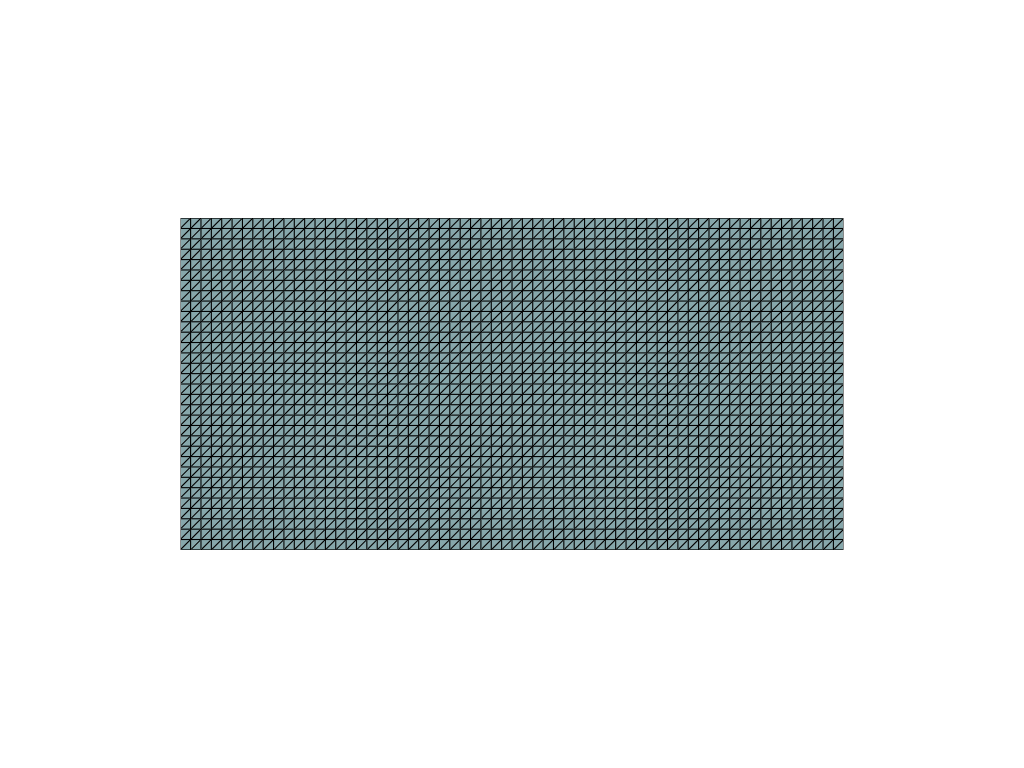

In [4]:
show_mesh()

## The finite element approximation space

First we choose the finite-element approximation space, e.g. the space
in which we search for an approximate solution of the problem. In
incompressible flow, the unknown variables are the vector-valued
velocity field $\mathbf{u}$ and the scalar pressure field $p$.

In the following we set up the discrete approximation spaces
$\mathbb{V}_h$ and $\mathbb{Q}_h$ for the velocity and pressure fields,
respectively.

In [ ]:
print_rank0("Setting up FEM spaces...")

# A vector-valued function space of degree 2
P2 = element(family="Lagrange", cell=mesh.basix_cell(), degree=2, shape=(mesh.geometry.dim,), dtype=default_real_type)
# A scalar-valued function space of degree 1
P1 = element(family="Lagrange", cell=mesh.basix_cell(), degree=1, dtype=default_real_type)

# Create the Taylot-Hood function space
TH = mixed_element([P2, P1])
W = functionspace(mesh, TH)

# Velocity and pressure function subspaces of the mixed function space
W0 = W.sub(0)
V_h, _ = W0.collapse()
W1 = W.sub(1)
Q_h, _ = W1.collapse()

Setting up FEM spaces...


Note that we can use the `sub()` function to access the subspaces of the
mixed function space `W`. In our case, we have two subspaces: one for
the velocity (`V_h`) and one for the pressure (`Q_h`).

In [ ]:
from ufl import (
    FacetNormal,
    Identity,
    TestFunction,
    TrialFunction,
    div,
    dot,
    ds,
    dx,
    inner,
    lhs,
    nabla_grad,
    rhs,
    sym,
)

# Mesh element surface normal:
n = FacetNormal(mesh)
# External body force source term:
f = Constant(mesh, PETSc.ScalarType((0, 0)))
# Time discretization timestep size:
Delta_t = Constant(mesh, PETSc.ScalarType(1))
# Dynamic viscosity:
mu = Constant(mesh, PETSc.ScalarType(1))

In [ ]:
a = lambda u, v: mu*inner(grad(u), grad(v)) * dx
b = lambda v, p: -inner(p, div(v)) * dx
L = lambda f, v: inner(f, v) * dx

# Define variational problem
(u_h, p_h) = ufl.TrialFunctions(W)
(v_h, q_h) = ufl.TestFunctions(W)

f = Function(V_h)
weak_form_stokes_lhs = form(
    a(u_h, v_h)
    + b(v_h, p_h)
    + b(u_h, q_h)
)

weak_form_stokes_rhs = form(inner(f, v_h) * dx)

## Couette flow boundary conditions

First we define markers for the boundary conditions. These are simple
functions that evaluate to 1 on the boundary where the condition is
applied and 0 elsewhere.

In [ ]:
# top boundary
def lid_boundary_marker(x):
    return np.isclose(x[1], 1.0)

# bottom boundary
def channel_bottom_boundary_marker(x):
    return np.isclose(x[1], 0.0)

noslip_zero_velocity_vector = Function(V_h)

Then we define an expression for the Dirichlet boundary value. Here, we
have to be careful to match the correct dimensions of the field we want
to prescribe.

In [ ]:
u_lid = 1.0

# insert vector [u, v] = [u_lid, 0]^T into all boundary DOFs
def lid_velocity_expression(x):
    return np.stack((u_lid*np.ones(x.shape[1]), np.zeros(x.shape[1])))

Match the geometrical description of the boundaries to boundary
conditions for the solver:

In [ ]:
boundary_conditions_couette = library.boundary.boundary_hw02_couette(mesh, W0, V_h, lid_velocity_expression, lid_boundary_marker, channel_bottom_boundary_marker)

## Solving the discrete variational problem

We now have the ingredients to build the closed linear system of
equations from the discrete weak form and the boundary conditions.

By telling FenicsX which finite element functions we are using and which
boundary conditions we have, we can have the FenicsX backend
automatically generate the linear system of equations
$\mathbf{A}\,\mathbf{x}= \mathbf{b}$ for us.

Solving the linear system is its own branch of science. If the matrix
$\mathbf{A}$ gets large it becomes impossible to invert it directly even
on today’s supercomputers. Instead, the system is solved iteratively
using [iterative
methods](https://en.wikipedia.org/wiki/Iterative_method).

Since this is not a course on numerical linear algebra and because our
problem size is small, we will avoid these complications and use a
direct solver implemented in the PETSc linear solver backend.

### Our solver function

The following function takes the weak form and boundary conditions and
solves the linear system. For convenience, it returns the sub-components
of the solution vector belonging to the velocity and pressure at the
degrees of freedom separately.

In [ ]:
# Initialize discrete function to hold the solution
U = Function(W)

# Create and configure solver
linear_solver = PETSc.KSP().create(mesh.comm)
linear_solver.setType("preonly")

petsc_preconditioner = linear_solver.getPC()
petsc_preconditioner.setType("lu")
petsc_preconditioner.setFactorSolverType("mumps")

opts = PETSc.Options()  # type: ignore
opts["mat_mumps_icntl_14"] = 80  # Increase MUMPS working memory
opts["mat_mumps_icntl_24"] = 1  # Option to support solving a singular matrix (pressure nullspace)
opts["mat_mumps_icntl_25"] = 0  # Option to support solving a singular matrix (pressure nullspace)
opts["ksp_error_if_not_converged"] = 1
linear_solver.setFromOptions()


# Assemble LHS matrix...
A = fem.petsc.assemble_matrix(weak_form_stokes_lhs, bcs=boundary_conditions_couette)
A.assemble()
linear_solver.setOperators(A)

# and create RHS vector. This will be filled during the solve step.
b = fem.petsc.create_vector(weak_form_stokes_rhs)

def solve_mixed_flow_problem(weak_form_lhs, weak_form_rhs, boundary_conditions):
    """
    Solve the (Navier-)Stokes problem in saddle point form using a direct solver.

    The function assembles the linear system Ax=b and solves it using the
    PETSc linear solver backend.

    In this particular implementation, we use
    a direct solver, which means that the matrix A is inverted to find x = A^{-1}*b.
    This avoids problem with ill-conditioning A, but is only applicable to small problems.
    """
    global U, linear_solver, petsc_preconditioner, A, b
    
    A.zeroEntries()
    fem.petsc.assemble_matrix(A, weak_form_lhs, bcs=boundary_conditions)
    A.assemble()

    with b.localForm() as loc_1:
        loc_1.set(0)
    fem.petsc.assemble_vector(b, weak_form_rhs)

    # Set the values of the Dirichlet boundary conditions in the matrix:
    fem.petsc.apply_lifting(b, [weak_form_lhs], bcs=[boundary_conditions])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, boundary_conditions)

    try:
        linear_solver.solve(b, U.x.petsc_vec)
        U.x.scatter_forward()
    except PETSc.Error as e:
        if e.ierr == 92:
            print_rank0("The required PETSc solver/preconditioner is not available. Exiting.")
            print_rank0(e)
            exit(0)
        else:
            raise e

    # Split the mixed solution and collapse
    u, p = U.sub(0).collapse(), U.sub(1).collapse()

    return u, p

With that we can now solve the Couette flow problem:

In [ ]:
from pathlib import Path
folder = Path(output_dir + "/results_couette")
folder.mkdir(exist_ok=True, parents=True)

# Solve using a non-blocked matrix and an LU solver
u, p = solve_mixed_flow_problem(weak_form_stokes_lhs, weak_form_stokes_rhs, boundary_conditions_couette
)

vtk_file_velocity_abs_path = folder / str("couette_velocity.pvd")
vtk_file_pressure_abs_path = folder / str("couette_pressure.pvd")
vtk_writer_u = dolfinx.io.VTKFile(mesh.comm, vtk_file_velocity_abs_path, "w+")
vtk_writer_p = dolfinx.io.VTKFile(mesh.comm, vtk_file_pressure_abs_path, "w+")
vtk_writer_u.write_function([u], t=0.0)
vtk_writer_p.write_function([p], t=0.0)

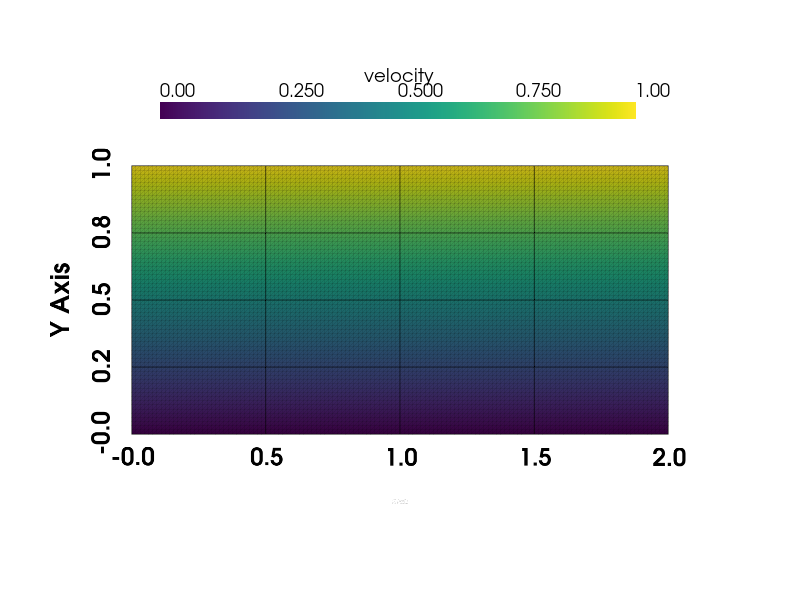

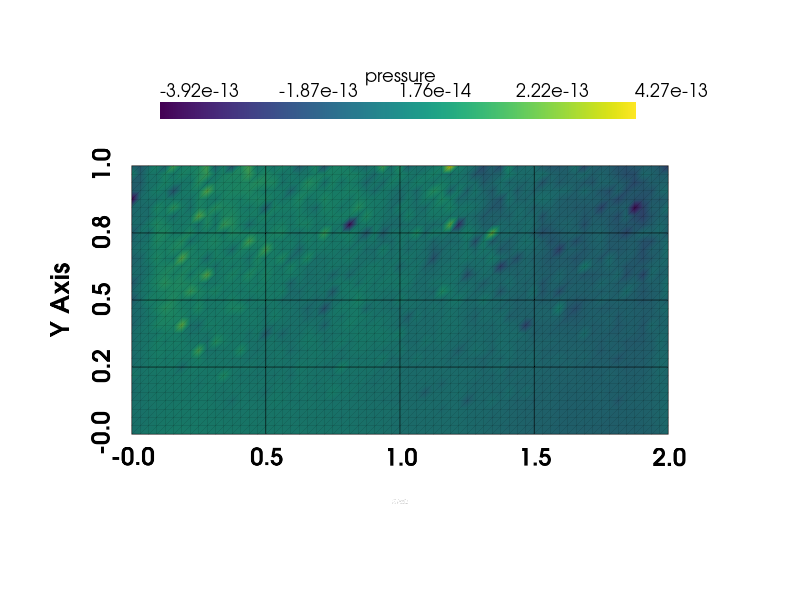

In [13]:
v_cg2 = element(family="Lagrange", cell=mesh.topology.cell_name(), degree=2, shape=(mesh.geometry.dim,))
s_cg1 = element(family="Lagrange", cell=mesh.basix_cell(), degree=1, dtype=default_real_type)

V_velocity = functionspace(mesh, v_cg2)
Q_pressure = functionspace(mesh, s_cg1)

u_sub = Function(V_velocity, name="velocity")
p_sub = Function(Q_pressure, name="pressure")

u_sub.interpolate(u)
p_sub.interpolate(p)

if interactive_mode_is_on:
    library.plot.contour_plot(u_sub, geometry_dim=2)
    library.plot.contour_plot(p_sub, geometry_dim=2)

## **Student TODO**: Verficiation of the numerical Couette flow solution

We never trust our numerical results until we have verified them
thoroughly.

Complete the function returning the analytical solution of the planar
Couette flow problem below, where `values` contains the vector valued
analytical solution (`values[0]`, `values[1]`). The $x$ and $y$
coordinates can be accessed via `x[0]` and `x[1]`, respectively.

In [ ]:
def u_exact_couette(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    
    # Since the velocity profile is linear and the velocity at y=1 is 1 m/s,
    # we can just return the coordinates of y as the velocity in x-directions.

    values[0] = x[1]

    return values

In [15]:
from dolfinx.fem import assemble_scalar, form

u_ex = Function(V_h)
u_ex.interpolate(u_exact_couette)

L2_error = form(dot(u - u_ex, u - u_ex) * dx)

error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
error_max = mesh.comm.allreduce(np.max(u.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)

print_rank0("L2 error with respect to the analytical solution: " + str(error_L2))
print_rank0("Maximum error at the degrees of freedom: " + str(error_max))

L2 error with respect to the analytical solution: 1.1274257398264608e-13
Maximum error at the degrees of freedom: 3.739952570635091e-15


In [16]:
def test_couette_solution():
    
    if (mesh.comm.rank == 0):
        if np.isclose(error_L2, 0.0, atol=1e-10) and np.isclose(error_max, 0.0, atol=1e-10):
            print_rank0("Steady couette test passed.")
        else:
            print_rank0("Steady couette test failed.")
            print_rank0(f"Expected error_L2: 0.0, got {error_L2}")
            print_rank0(f"Expected error_max: 0.0, got {error_max}")


test_couette_solution()

Steady couette test passed.


# Cylinder flow: The Navier-Stokes Equations

We now move on to a classical problem with a little more complex
geometry: flow around a cylinder.

Let’s get started by loading the new mesh:

In [17]:
import gmsh
from dolfinx.io import gmshio

folder_abs_path = os.path.abspath("")
mesh_file_abs_path = os.path.join(folder_abs_path, "library", "data_hw03", "cylinder_mesh", "cylinder.msh")

# load gmsh model from file
gmsh.initialize()
gmsh.open(mesh_file_abs_path)

mesh_comm = MPI.COMM_WORLD
model_rank = 0
gdim = 2

mesh, _, ft = gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)
# get parent directory of notebook
gmsh.finalize()

Info    : Reading '/home/wi867179/CMM/library/data_hw03/cylinder_mesh/cylinder.msh'...
Info    : 11 entities
Info    : 7584 nodes
Info    : 2064 elements
Info    : Done reading '/home/wi867179/CMM/library/data_hw03/cylinder_mesh/cylinder.msh'


Show mesh...


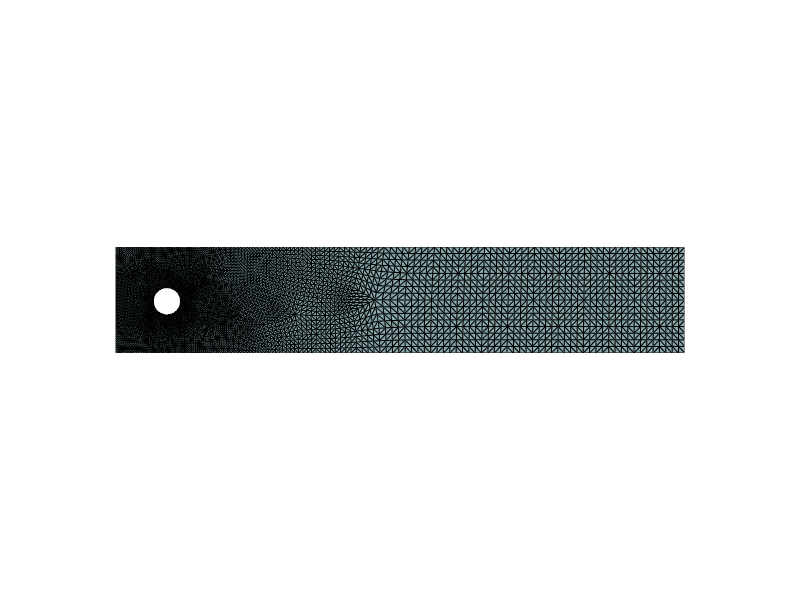

In [18]:
show_mesh()

Since we have changed the discrete domain, we also need to redefine the
finite element spaces for the velocity and pressure fields:

In [19]:
# A vector-valued function space of degree 2
P2 = element(family="Lagrange", cell=mesh.basix_cell(), degree=2, shape=(mesh.geometry.dim,), dtype=default_real_type)
# A scalar-valued function space of degree 1
P1 = element(family="Lagrange", cell=mesh.basix_cell(), degree=1, dtype=default_real_type)

# Create the Taylot-Hood function space
TH = mixed_element([P2, P1])
W = functionspace(mesh, TH)

# Velocity and pressure function subspaces of the mixed function space
W0 = W.sub(0)
V_h, _ = W0.collapse()
W1 = W.sub(1)
Q_h, _ = W1.collapse()

In [20]:
u_n = Function(V_h, name="u_n")
""" Velocity at previous time step (index n) """

u_nm1 = Function(V_h, name="u_nm1")
""" Velocity at second to last time step (index n-1), used in BDF2 stencil """

p_n = Function(Q_h, name="p_n")
""" Pressure at previous time step (index n) """

' Pressure at previous time step (index n) '

# Mixed finite elements for Navier-Stokes

The incompressible Navier-Stokes equations for a Newtonian fluid are
given by 
$$
\begin{aligned}
\rho\,\left(\frac{\partial \mathbf{u}}{\partial t} +  \mathbf{u}\cdot\boldsymbol{\nabla}\mathbf{u} \right) & =  - \nabla p + \mu \, \Delta \mathbf{u}  + \mathbf{f}  \quad \text{in } \Omega, \\
\nabla \cdot \mathbf{u} &= 0 \quad \text{in } \Omega.
\end{aligned}
$$

with boundary conditions

$$
\begin{aligned}
\mathbf{u} &= \mathbf{u}_D \quad  & \text{on } \Gamma_D, \\
\boldsymbol{\nabla}\mathbf{u}\cdot\mathbf{n} - p\,\mathbf{n}  &= \mathbf{g} \quad & \text{on } \Gamma_N,
\end{aligned}
$$

where $\mathbf{u}_D$ is the velocity on the Dirichlet boundary
$\Gamma_D$, $\mathbf{g}$ is the natural boundary condition, and
$\mathbf{n}$ is the outward unit normal.

## The weak formulation

Here, we consider the following mixed weak formulation of the
Navier-Stokes equations: Find
$(\mathbf{u}, p) \in \mathbb{V} \times \mathbb{Q}$ such that

$$
\begin{aligned}
\int_{\Omega} \rho\, \frac{\partial \mathbf{u}}{\partial t}\,\mathbf{v}\,\text{d}x + \int_{\Omega} \rho \, \left(\mathbf{u}\cdot\boldsymbol{\nabla}\mathbf{u}\right)\cdot\mathbf{v}\,\text{d}x+ \int_{\Omega} \mu \, \nabla \mathbf{u} : \nabla \mathbf{v} \, \text{d}x - \int_{\Omega} p \, \nabla \cdot \mathbf{v} \, \text{d}x  &= \int_{\Omega} \mathbf{f} \cdot \mathbf{v} \, \text{d}x + \int_{\Gamma^N} \mathbf{g} \cdot \mathbf{v} \, \text{d}S \quad \forall \, \mathbf{v} \in \mathbb{V}, \\
\int_{\Omega} \nabla \cdot \mathbf{u} \, q \, \text{d}x &= 0 \quad \forall \, q \in \mathbb{Q}.
\end{aligned}
$$

which can be written as

$$
\begin{aligned}
\int_{\Omega} \rho\, \frac{\partial \mathbf{u}}{\partial t}\,\text{d}x
+ c(\mathbf{u}, \mathbf{u}, \mathbf{v})
+ a(\mathbf{u}, \mathbf{v}) + b(\mathbf{v}, p) &= L(\mathbf{v}) \quad \forall \, \mathbf{v} \in \mathbb{V}, \\
b(\mathbf{u}, q) &= 0 \quad \forall \, q \in \mathbb{Q} \\
\end{aligned}
$$

with

$$
\begin{aligned}
c \,:\, \mathbb{R}^d \times \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}\,, \quad & c(\mathbf{u}, \mathbf{v}, \mathbf{w}) = \int_{\Omega} \rho\,\left(\mathbf{u}\cdot\boldsymbol{\nabla}\mathbf{v}\right) \cdot \mathbf{w} \, \text{d}x,  \\
a \,:\, \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}\,, \quad & a(\mathbf{u}, \mathbf{v}) = \int_{\Omega} \mu \, \nabla \mathbf{u} : \nabla \mathbf{v} \, \text{d}x  \\
b \,:\, \mathbb{R}^d \times \mathbb{R} \to \mathbb{R}\,, \quad & b(\mathbf{u}, q) = -\int_{\Omega} \nabla \cdot \mathbf{u} \, q \, \text{d}x, \\
L \,:\, \mathbb{R}^d \to \mathbb{R}\,, \quad & L(\mathbf{v}) = \int_{\Omega} \mathbf{f} \cdot \mathbf{v} \, \text{d}x + \int_{\Gamma^N} \mathbf{g} \cdot \mathbf{v} \,\text{d}S.
\end{aligned}
$$

In [21]:
from ufl import (
    FacetNormal,
    Identity,
    TestFunction,
    TrialFunction,
    div,
    dot,
    ds,
    dx,
    inner,
    lhs,
    nabla_grad,
    rhs,
    sym,
)

# Current time
t = 0

# Mesh element surface normal:
n = FacetNormal(mesh)
# External body force source term:
f = Constant(mesh, PETSc.ScalarType((0, 0)))
# Dynamic viscosity:
mu = Constant(mesh, PETSc.ScalarType(0.001))
# Density:
rho = Constant(mesh, PETSc.ScalarType(1))

u_validation = Function(V_h, name="u_validation")
""" Velocity at which to compute the validation quantities of interest """

p_validation = Function(Q_h, name="p_validation")
""" Pressure at which to compute the validation quantities of interest """

p_n = Function(Q_h, name="p_n")
""" Pressure at previous time step (index n) (used later in the transient solver) """

' Pressure at previous time step (index n) (used later in the transient solver) '

The weak form for the discrete problems will be formulated below in two
steps. First we consider only the steady part and then add the
discretization of the time derivative.

## Cylinder boundary conditions

The following tags are used in the mesh definition to identify the
different boundaries:

In [22]:
inlet_marker_tag, outlet_marker_marker_tag, wall_marker_tag, cylinder_obstacle_marker_tag = 2, 3, 4, 5

noslip_zero_velocity_vector = Function(V_h)

In the cylinder flow problem, the Dirichlet part of the boundary
$\Gamma_D$ consists of the inlet boundary (*left*, `inlet_marker_tag`),
the top and bottom wall boundaries (`wall_marker_tag`) and the cylinder
surface (`cylinder_obstacle_marker_tag`). On the wall boundaries and on
the cylinder surface, we prescribe a no-slip condition, i.e. the
velocity is zero. On the inlet boundary, we prescribe a parabolic inflow
velocity profile.

Natural boundary conditions with $\mathbf{g} = 0$ are applied on the
outlet boundary $\Gamma_N$ (*right*, `outlet_marker_marker_tag`) and we
therefore don’t have to define a boundary condition there explictly.

In [23]:
u_inlet, boundary_conditions_cylinder_flow = library.boundary.boundary_hw02_cylinder_flow(mesh, ft, W, W0, W1, V_h, Q_h, inlet_marker_tag, wall_marker_tag, cylinder_obstacle_marker_tag, outlet_marker_marker_tag)

## Verification: Lift and Drag coefficients, pressure difference

As a verification of our implementation, we compute the drag and lift
coefficients over the obstacle, defined as

$$
    C_{\text{D}}(u,p,t,\partial\Omega_S) = \frac{2}{\rho \,D \,U_{mean}^2}\int_{\partial\Omega_S}\rho\, \nu\, \left(\mathbf{n} \cdot \nabla u_{t_S}(t)\right)\,n_y -p(t)\,n_x~\mathrm{d} s,
$$

$$
    C_{\text{L}}(u,\,p,\,t,\,\partial\Omega_S) = -\frac{2}{\rho \,D\, U_{mean}^2}\int_{\partial\Omega_S}\rho\, \nu \left(\mathbf{n} \cdot \nabla u_{t_S}(t)\right)\,n_x + p(t)\,n_y~\mathrm{d} s,
$$

where $u_{t_S}$ is the tangential velocity component at the interface of
the cylindrical obstacle $\partial\Omega_S$, defined as
$u_{t_S}=u\cdot (n_y,-n_x)$, $U_{mean}=1$ the average inflow velocity,
and $D=0.1$ the cylinder diameter. We use `UFL` to create the relevant
integrals, and assemble them at each time step.

We also compute the pressure difference `p_diff` between the leading and
trailing edge of the cylinder.

In [24]:
from ufl import Measure, as_vector

n = -FacetNormal(mesh)  # Normal pointing out of obstacle

dObs = Measure("ds", domain=mesh, subdomain_data=ft, subdomain_id=cylinder_obstacle_marker_tag)
u_t = inner(as_vector((n[1], -n[0])), u_validation)
U_mean_validation = Constant(mesh, PETSc.ScalarType(1.0))

drag = form(2  / (rho*0.1*U_mean_validation**2) * (mu / rho * inner(grad(u_t), n) * n[1] - p_validation * n[0]) * dObs)
lift = form(-2 / (rho*0.1*U_mean_validation**2) * (mu / rho * inner(grad(u_t), n) * n[0] + p_validation * n[1]) * dObs)

def setup_verification_arrays(num_steps):
    """
    Set up arrays to store verification data.
    """
    global C_D, C_L, t_u, t_p, p_diff
    
    C_D = np.zeros(num_steps, dtype=PETSc.ScalarType)
    C_L = np.zeros(num_steps, dtype=PETSc.ScalarType)
    t_u = np.zeros(num_steps, dtype=np.float64)
    t_p = np.zeros(num_steps, dtype=np.float64)
    p_diff = np.zeros(num_steps, dtype=PETSc.ScalarType)

    return C_D, C_L, t_u, t_p, p_diff

We will also evaluate the pressure at two points, one in front of the
obstacle, $(0.15, 0.2)$, and one behind the obstacle, $(0.25, 0.2)$. To
do this, we have to find which cell contains each of the points, so that
we can create a linear combination of the local basis functions and
coefficients.

The quantities of interest at a given time step are computed in the
following function:

In [25]:
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells

def compute_cylinder_qois(time_index, time):
    """
    Compute quantities of interest on the cylindrical obstacle:

    - Drag coefficient
    - Lift coefficient
    - Pressure difference between front and back of the cylinder

    For this to work in parallel, we gather contributions from all processors
    to processor zero and sum the contributions.
    """
    global C_D, C_L, t_u, t_p, p_diff
    
    tree = bb_tree(mesh, mesh.geometry.dim)
    points = np.array([[0.15, 0.2, 0], [0.25, 0.2, 0]])
    cell_candidates = compute_collisions_points(tree, points)
    colliding_cells = compute_colliding_cells(mesh, cell_candidates, points)
    front_cells = colliding_cells.links(0)
    back_cells = colliding_cells.links(1)

    drag_coeff = mesh.comm.gather(assemble_scalar(drag), root=0)
    lift_coeff = mesh.comm.gather(assemble_scalar(lift), root=0)

    p_front = None
    if len(front_cells) > 0:
        p_front = p_validation.eval(points[0], front_cells[:1])
    p_front = mesh.comm.gather(p_front, root=0)

    p_back = None
    if len(back_cells) > 0:
        p_back = p_validation.eval(points[1], back_cells[:1])
    p_back = mesh.comm.gather(p_back, root=0)

    if mesh.comm.rank == 0:
        t_u[time_index] = time
        # t_p[i] = t - dt / 2
        t_p[time_index] = time
        C_D[time_index] = sum(drag_coeff)
        C_L[time_index] = sum(lift_coeff)
        # Choose first pressure that is found from the different processors
        for pressure in p_front:
            if pressure is not None:
                p_diff[time_index] = pressure[0]
                break
        for pressure in p_back:
            if pressure is not None:
                p_diff[time_index] -= pressure[0]
                break

### Re-initialize the linear solver

Since the mesh has changed, we need to re-initialize the linear solver
and matrix (sizes) for the new mesh and boundary conditions.

In [26]:
def setup_linear_solver(weak_form_lhs, weak_form_rhs, boundary_conditions):

    global U, linear_solver, petsc_preconditioner, A, b
    # Initialize discrete function to hold the solution
    U = Function(W)

    # Create and configure solver
    linear_solver = PETSc.KSP().create(mesh.comm)
    linear_solver.setType("preonly")

    petsc_preconditioner = linear_solver.getPC()
    petsc_preconditioner.setType("lu")
    petsc_preconditioner.setFactorSolverType("mumps")

    linear_solver.setFromOptions()

    # Assemble LHS matrix...
    A = fem.petsc.assemble_matrix(weak_form_lhs, bcs=boundary_conditions)
    A.assemble()
    linear_solver.setOperators(A)

    # and create RHS vector. This will be filled during the solve step.
    b = fem.petsc.create_vector(weak_form_rhs)

## Cylinder flow 1: The steady flow around a cylinder

In the first part of the problem, we consider the steady limit of the
Navier-Stokes equations, i.e. we set the time derivative
$\partial \mathbf{u} / \partial t$ to zero.

We hence seek to add only the convective term to the weak form of the
Stokes equations previously considered and the weak form becomes

$$
\begin{aligned}
c(\mathbf{u}, \mathbf{u}, \mathbf{v})
+ a(\mathbf{u}, \mathbf{v}) + b(\mathbf{v}, p) &= L(\mathbf{v}) \quad \forall \, \mathbf{v} \in \mathbb{V}, \\
b(\mathbf{u}, q) &= 0 \quad \forall \, q \in \mathbb{Q} \\
\end{aligned}
$$

with definitions given earlier above.

One fundamental problem with the convective term

$$
c(\mathbf{u}, \mathbf{u}, \mathbf{v}) = \int_{\Omega} \rho\,\left(\mathbf{u}\cdot\boldsymbol{\nabla}\mathbf{u}\right) \cdot \mathbf{v} \, \text{d}x
$$

is that it is not linear in $\mathbf{u}$ (it contains the product of
terms involving $\mathbf{u}$). That means that we can no longer use a
simple linear solver to find the minimum of the residual.

Classically, there is two approaches to deal with this problem:

-   Use a nonlinear solver such as Newton’s method or a fixed point
    iteration to iteratively solve the nonlinear problem.
-   Use a linearization of the convective term, e.g. replace the first
    argument of $c(\mathbf{u}, \mathbf{u}, \mathbf{v})$ with an
    approximation $\mathbf{u}^{*}$ as a function of a known velocity
    field.

#### An iterative steady state solver

To solve the steady cylinder flow problem, we will implement a nonlinear
iteration with steps $k$ to find the steady state. In each iteration,
the advective velocity velocity $\mathbf{u}^{*}$ is set to the last
known approxiation, the solution $\mathbf{u}^{k}$ from the previous
iteration.

Upon convergence, the solution $\mathbf{u}^{k}$ will be the steady state
solution of the cylinder flow problem.

In [27]:
u_k = Function(V_h, name="u_k")
""" Last known velocity field, solution to the previous nonlinear iteration k"""

p_k = Function(Q_h, name="p_k")
""" Last known pressure field, solution to the previous nonlinear iteration k"""

' Last known pressure field, solution to the previous nonlinear iteration k'

### **Student TODO**: Linearized convective term

Given $\mathbf{u}^{k}$, implement the linearized convective term
$c(\mathbf{u}^k, \mathbf{u}, \mathbf{v})$ below.

**Note:** The ufl operator `nabla_grad(u)` gives the Jacobian of the
velocity field consistent with the general definition of
$c(\mathbf{u}, \mathbf{u}, \mathbf{v})$ above.

In [28]:
# Your code here: c = lambda u, v: ...
c = lambda u, v: rho * inner(dot(u_k, nabla_grad(u)), v) * dx

The rest of the weak form than is the same as before:

In [29]:
a = lambda u, v: mu * inner(grad(u), grad(v)) * dx
b = lambda v, p: -inner(p, div(v)) * dx
L = lambda f, v: inner(f, v) * dx

# Define variational problem
(u_h, p_h) = ufl.TrialFunctions(W)
(v_h, q_h) = ufl.TestFunctions(W)

f = Function(V_h)

weak_form_navier_stokes_steady = (
    c(u_h, v_h) + a(u_h, v_h) + b(v_h, p_h) + b(u_h, q_h) - L(f, v_h)
)

weak_form_navier_stokes_steady_lhs = form(lhs(weak_form_navier_stokes_steady))
weak_form_navier_stokes_steady_rhs = form(rhs(weak_form_navier_stokes_steady))

In [30]:
def nonlinear_steady_solver(simulation_name: str, weak_form_lhs, weak_form_rhs, boundary_conditions, inlet_velocity_profile, nonlinear_tolerance=1e-6, max_nonlinear_iterations=100):
    """Perform a fixed-point iteration on the explicit discretization of the Navier-Stokes equations 
    to find the steady state solution of the flow around a cylinder.
    """
    
    # Use first order timestepping in the first timestep, 
    # and second order in the subsequent timesteps
    print_rank0("Starting time loop for simulation: " + simulation_name)

    setup_linear_solver(weak_form_lhs, weak_form_rhs, boundary_conditions)
    u_k.interpolate(noslip_zero_velocity_vector)
    U_mean_validation.value = (2/3)*inlet_velocity_profile.U_max

    if mesh.comm.rank == 0:
        # Initialize arrays to store verification data
        C_D, C_L, t_u, t_p, p_diff = setup_verification_arrays(1)

    # Handle file IO: write output to VTX files:
    from pathlib import Path
    folder = Path(output_dir + "/out_" + simulation_name)
    folder.mkdir(exist_ok=True, parents=True)

    vtk_file_velocity_abs_path = folder / str(simulation_name + "_velocity.pvd")
    vtk_file_pressure_abs_path = folder / str(simulation_name + "_pressure.pvd")

    vtk_writer_u = dolfinx.io.VTKFile(mesh.comm, vtk_file_velocity_abs_path, "w+")
    vtk_writer_p = dolfinx.io.VTKFile(mesh.comm, vtk_file_pressure_abs_path, "w+")
    vtk_writer_u.write_function([u_k], t=0.0)
    vtk_writer_p.write_function([p_n], t=0.0)

    u_inlet.interpolate(inlet_velocity_profile)
    # Solve the problem until pressure difference 
    # between front and back of the cylinder converges: 
    max_iter = 0
    progress = tqdm.autonotebook.tqdm(desc="Nonlinear iterations", total=max_nonlinear_iterations)
    
    for i in range(max_nonlinear_iterations):

        progress.update(1)
        # Solve the problem
        u_sol, p_sol = solve_mixed_flow_problem(
            weak_form_lhs, weak_form_rhs, boundary_conditions
        )

        max_velocity_error = (u_sol.x.petsc_vec.array - u_k.x.petsc_vec.array).max()
        max_pressure_error = (p_sol.x.petsc_vec.array - p_k.x.petsc_vec.array).max()

        u_k.interpolate(u_sol)
        p_k.interpolate(p_sol)

        max_convergence_error = max(max_velocity_error, max_pressure_error)
        if max_convergence_error < nonlinear_tolerance:
            print_rank0(f"Nonlinear solver converged after {i+1} iterations.")
            break

        max_iter = i 

    print_rank0(f"Maximum convergence error: {max_convergence_error} after {max_iter} iterations.")
    
    u_validation.interpolate(u_k)
    p_validation.interpolate(p_k)
    # Compute quantities of interest
    compute_cylinder_qois(0, time=1.0)

    vtk_writer_u.write_function([u_k], t=1.0)
    vtk_writer_p.write_function([p_k], t=1.0)
    progress.close()

For the transient case, we consider a parabolic inflow velocity profile
at the inlet boundary, which is given by

$$
\mathbf{U}_{\text{inflow}}(t) = \begin{pmatrix} \frac{4 \, U_{\text{max}}  \, y \, (0.41 - y)}{0.41^2} \\ 0 \end{pmatrix}
$$

The Reynolds number of the flow can be controlled via the maximum
velocity $U_{\text{max}}$ at the inlet boundary.

In [31]:
class InletVelocitySteady:
    """ 
    Implement the steady parabolic inlet velocity profile for the cylinder flow problem. 
    """

    def __init__(self, U_max):
        self.U_max = U_max
        """ Maximum inlet velocity (parabola peak) """

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = 4 * self.U_max * x[1] * (0.41 - x[1]) / (0.41**2)
        return values

### Student TODO: Steady inflow velocity / Reynolds number

An approximate Reynolds number for the problem is given by

$$ \text{Re} = \frac{U_{mean} L}{\nu} $$

where $U_{mean} = (2/3) U_{\text{max}}$ is the average inflow velocity,
the characteristic length scale $L = D_{\text{cylinder}}=0.1$ is given
by the cylinder diameter, and $\nu = 0.001$ is the kinematic viscosity.

Given these parameters, set the maximum inflow velocity $U_{\text{max}}$
to achieve a Reynolds number of $\text{Re} = 20$. Assign the correct
value for $U_{\text{max}}$ to a variable `U_max_steady` below.

In [32]:
# Your code here 
L = 0.1
nu = 0.001
Re = 20
U_max_steady = (3/2) * Re * nu / L # should result in -> U_max_steady = 0.3

In [33]:
inlet_velocity_steady = InletVelocitySteady(U_max_steady)

nonlinear_steady_solver("cylinder_navier_stokes_steady", weak_form_navier_stokes_steady_lhs, weak_form_navier_stokes_steady_rhs, boundary_conditions_cylinder_flow, inlet_velocity_steady, nonlinear_tolerance=1e-6, max_nonlinear_iterations=40)

Starting time loop for simulation: cylinder_navier_stokes_steady


Nonlinear iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Nonlinear solver converged after 13 iterations.
Maximum convergence error: 5.610352818985476e-07 after 11 iterations.


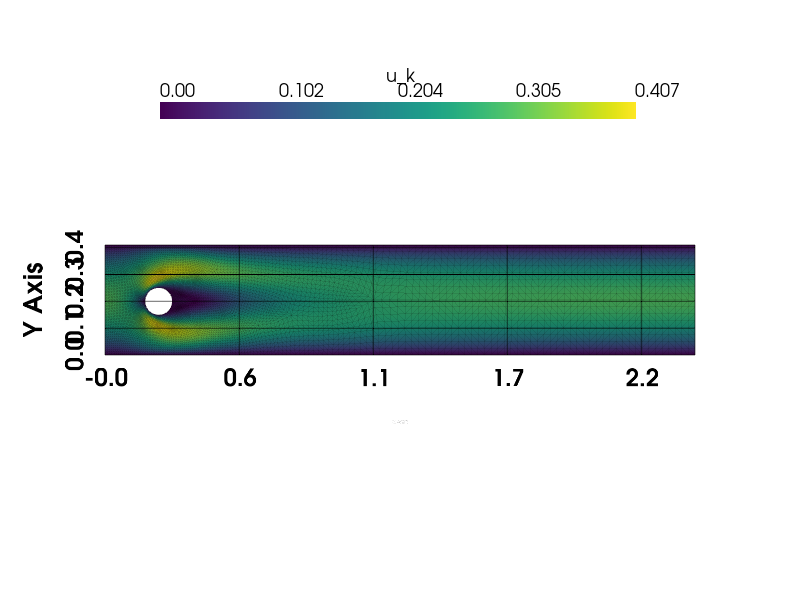

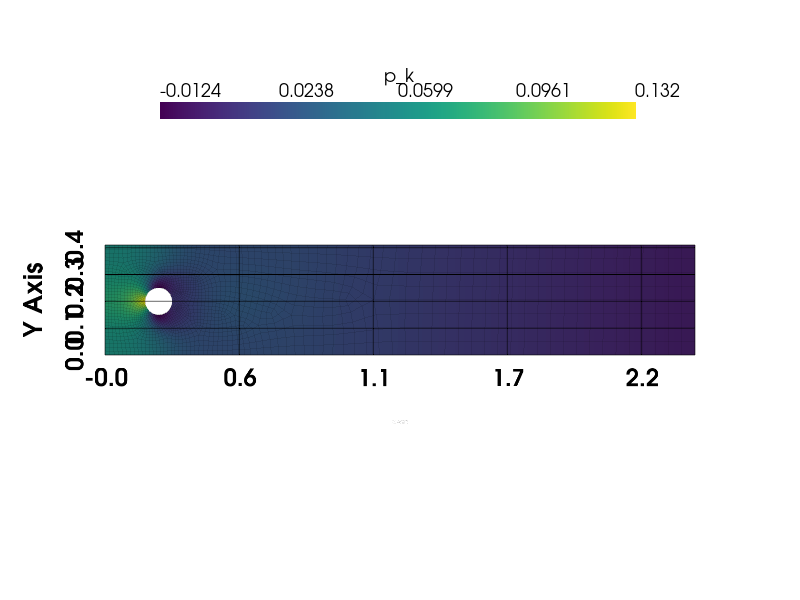

In [34]:
if interactive_mode_is_on:
    library.plot.contour_plot(u_k, geometry_dim=2)
    library.plot.contour_plot(p_k, geometry_dim=2)

In [35]:
def test_cylinder_flow_steady():
    global p_diff

    if (mesh.comm.rank == 0):
        if np.isclose(p_diff, 0.11762863, atol=1e-6):
            print_rank0("Steady cylinder flow test passed.")
        else:
            print_rank0("Steady cylinder flow test failed.")
            print_rank0(f"Expected p_diff: 0.11762863, but got {p_diff}")

test_cylinder_flow_steady()

Steady cylinder flow test passed.


## Cylinder flow 2: The transient problem

In the final part of the homework exercise, we add the time derivative
to the weak form of the Navier-Stokes equations. One of the simplest
ways to this is to use a backward differentiation formula (BDF) to
approximate the time derivative, which we will do here.

#### Time discretization coefficients:

The time derivative $\frac{\partial \mathbf{u}}{\partial t}$ is
approximated by 
$$
\frac{\partial \mathbf{u}}{\partial t} \approx \frac{\gamma_0 \,\mathbf{u} + \gamma_1\,\mathbf{u}_n + \gamma_2\,\mathbf{u}_{n-1}}{\Delta t}
$$

where $\mathbf{u}_n$ is the velocity at the previous time step (index
n), $\mathbf{u}_{n-1}$ is the velocity at the second to last time step
(index n-1).

In [36]:
u_n = Function(V_h, name="u_n")
""" Velocity at previous time step (index n) """

u_nm1 = Function(V_h, name="u_nm1")
""" Velocity at second to last time step (index n-1), used in BDF2 stencil """

' Velocity at second to last time step (index n-1), used in BDF2 stencil '

The time discretization stencil coefficients determine the order of the
time discretization scheme, see
https://en.wikipedia.org/wiki/Finite_difference_coefficient and
https://en.wikipedia.org/wiki/Backward_differentiation_formula .

In the first timestep use the first order **BDF1** scheme, which is
equivalent to the implicit Euler scheme, where $\gamma_0 = 1$,
$\gamma_1 = -1$, $\gamma_2 = 0$

In [37]:
gamma_0 = Constant(mesh, PETSc.ScalarType(1.0))
""" First coefficient for the BDF2 time-stepping scheme, used in the transient solver """
gamma_1 = Constant(mesh, PETSc.ScalarType(-1.0))
""" Second coefficient for the BDF2 time-stepping scheme, used in the transient solver """
gamma_2 = Constant(mesh, PETSc.ScalarType(0.0))
""" Third coefficient for the BDF2 time-stepping scheme, used in the transient solver 
This coefficient is zero in the BDF1 scheme, but non-zero if the BDF2 scheme is used.
"""

dt = Constant(mesh, PETSc.ScalarType(1/1600))
""" Time step size for the transient solver """

' Time step size for the transient solver '

### **Student TODO**: The transient term

Implement the discrete weak form transient term

$$ \int_{\Omega} \rho\, \frac{\partial \mathbf{u}}{\partial t}\cdot\mathbf{v}\,\text{d}x $$

given the discrete approximation of the time derivative above. Use the
provided `gamma` coefficients to compute the approximate time derivative
term.

In [38]:
# Your code here: transient_term = lambda u, v: ...
time_derivative = lambda u: (gamma_0*u + gamma_1*u_n + gamma_2*u_nm1)/dt
transient_term = lambda u, v: rho * inner(time_derivative(u), v) * dx

In [39]:
c = lambda u, v: rho * inner(dot(u_n, nabla_grad(u)), v) * dx
a = lambda u, v: mu * inner(grad(u), grad(v)) * dx
b = lambda v, p: -inner(p, div(v)) * dx
L = lambda f, v: inner(f, v) * dx

# Define variational problem
(u_h, p_h) = ufl.TrialFunctions(W)
(v_h, q_h) = ufl.TestFunctions(W)

f = Function(V_h)

weak_form_navier_stokes_transient = (
    transient_term(u_h, v_h) + c(u_h, v_h) + a(u_h, v_h) + b(v_h, p_h) + b(u_h, q_h) - L(f, v_h)
)

weak_form_navier_stokes_transient_lhs = form(lhs(weak_form_navier_stokes_transient))
weak_form_navier_stokes_transient_rhs = form(rhs(weak_form_navier_stokes_transient))

#### Time loop

In this function we implement the iteration in time for the transient
problem.

In [40]:
def solve_time_loop(simulation_name: str, weak_form_lhs, weak_form_rhs, boundary_conditions, inlet_velocity_profile, num_timesteps: int, write_solution_every_n_steps = 20):
    """Solve the Navier-Stokes equations for the cylinder flow problem.

    This function sets up the time loop for the simulation, initializes the
    necessary variables, and solves the problem using a time-stepping method.
    """
    
    # Use first order timestepping in the first timestep, 
    # and second order in the subsequent timesteps
    print_rank0("Starting time loop for simulation: " + simulation_name)

    setup_linear_solver(weak_form_lhs, weak_form_rhs, boundary_conditions)

    gamma_0.value = 1.0
    gamma_1.value = -1.0
    gamma_2.value = 0.0

    # Set initial zero conditions
    u_n.interpolate(noslip_zero_velocity_vector)
    u_nm1.interpolate(noslip_zero_velocity_vector)
    t = 0.0
    U_mean_validation.value = (2/3)*inlet_velocity_profile.U_max

    if mesh.comm.rank == 0:
        # Initialize arrays to store verification data
        C_D, C_L, t_u, t_p, p_diff = setup_verification_arrays(num_steps)


    # Handle file IO: write output to VTX files:
    from pathlib import Path
    folder = Path(output_dir + "/out_" + simulation_name)
    folder.mkdir(exist_ok=True, parents=True)

    vtk_file_velocity_abs_path = folder / str(simulation_name + "_velocity.pvd")
    vtk_file_pressure_abs_path = folder / str(simulation_name + "_pressure.pvd")
    vtk_writer_u = dolfinx.io.VTKFile(mesh.comm, vtk_file_velocity_abs_path, "w+")
    vtk_writer_p = dolfinx.io.VTKFile(mesh.comm, vtk_file_pressure_abs_path, "w+")
    vtk_writer_u.write_function([u_n], t=0.0)
    vtk_writer_p.write_function([p_n], t=0.0)

    # Visualize progress of the time loop
    progress = tqdm.autonotebook.tqdm(desc="Solving PDE", total=num_steps)

    # Solve the problem
    for i in range(num_steps):
        progress.update(1)

        # Update the time
        t += dt.value
        # Update the inlet velocity
        # Update inlet velocity
        inlet_velocity_profile.t = t
        u_inlet.interpolate(inlet_velocity_profile)

        # Solve the problem
        u_sol, p_sol = solve_mixed_flow_problem(
            weak_form_lhs, weak_form_rhs, boundary_conditions
        )

        u_nm1.interpolate(u_n)
        u_n.interpolate(u_sol)
        p_n.interpolate(p_sol)

        # Compute quantities of interest such as drag and lift on the cylinder
        u_validation.interpolate(u_sol)
        p_validation.interpolate(p_sol)
        compute_cylinder_qois(i, time=t)

        # Write solutions to file
        if i % write_solution_every_n_steps == 0:
            vtk_writer_u.write_function([u_n], t=t)
            vtk_writer_p.write_function([p_n], t=t)

    progress.close()

For the transient case, we consider a time dependent parabolic inflow
velocity profile at the inlet boundary, which is given by 
$$
\mathbf{U}_{\text{inflow}}(t) = \begin{pmatrix} \frac{4 \, U_{\text{max}}  \, y \, (0.41 - y)}{0.41^2}\, \sin\left(\frac{\pi t}{8}\right) \\ 0 \end{pmatrix}
$$

where $t$ is the time in seconds.

Here, the inflow parabola from the steady case is multiplied by a time
dependent factor $\sin(\pi t / 8)$, which oscillates between 0 and 1.

In [41]:
class InletVelocityTransient:
    """ 
    Implement a transient parabolic inlet velocity profile for the cylinder flow problem that 
    is modulated by a sine function to simulate a time-dependent inlet condition.
    """
    
    def __init__(self, U_max, t):
        self.t = t
        """ Time value for transient velocity profile """

        self.U_max = U_max
        """ Maximum inlet velocity (parabola peak) """

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = 4 * self.U_max * np.sin(self.t * np.pi / 8) * x[1] * (0.41 - x[1]) / (0.41**2)
        return values

### **Student TODO**: Transient inflow velocity / Reynolds number

An approximate Reynolds number for the problem is given by

$$ \text{Re} = \frac{U_{mean} L}{\nu} $$

where $U_{mean} = (2/3) U_{\text{max}}$ is the average inflow velocity,
the characteristic length scale $L = D_{\text{cylinder}}=0.1$ is given
by the cylinder diameter, and $\nu = 0.001$ is the kinematic viscosity.

Given these parameters, set the maximum inflow velocity $U_{\text{max}}$
to achieve a Reynolds number of $\text{Re} = 100$. Assign the value to a
variable called `U_max_transient`.

In [42]:
# Your code here
L = 0.1
nu = 0.001
Re = 100
U_max_transient = (3/2) * Re * nu / L # should result in -> U_max_transient = 1.5


Of course we want to simulate a cool vortex street, but before we spend
the time waiting for the long simulation to finish, we first test that
everything works correctly by just running a few timesteps:

In [43]:
dt.value = 1 / 1600
num_steps = 100
inlet_velocity_transient = InletVelocityTransient(U_max_transient, t)
solve_time_loop("cylinder_navier_stokes_transient_check", weak_form_navier_stokes_transient_lhs, weak_form_navier_stokes_transient_rhs, boundary_conditions_cylinder_flow, inlet_velocity_transient, num_steps, write_solution_every_n_steps = 30)

Starting time loop for simulation: cylinder_navier_stokes_transient_check


Solving PDE:   0%|          | 0/100 [00:00<?, ?it/s]

In [44]:
transient_test_passed = False

def test_cylinder_flow_transient():
    global p_diff, C_D, C_L, transient_test_passed

    if (mesh.comm.rank == 0):
        if np.isclose(p_diff[-1], 0.10814227487139727, atol=1e-8) and np.isclose(C_D[-1], 0.19479961364168397, atol=1e-8) and np.isclose(C_L[-1], -0.00043242044385149525, atol=1e-8):
            print_rank0("Transient cylinder flow test passed.")
            transient_test_passed = True
        else:
            print_rank0("Transient cylinder flow test failed.")
            print_rank0(f"Expected p_diff: 0.10814227487139727, but got {p_diff[-1]}")
            print_rank0(f"Expected C_D: 0.19479961364168397, but got {C_D[-1]}")
            print_rank0(f"Expected C_L: -0.00043242044385149525, but got {C_L[-1]}")
            transient_test_passed = False

test_cylinder_flow_transient()

Transient cylinder flow test passed.


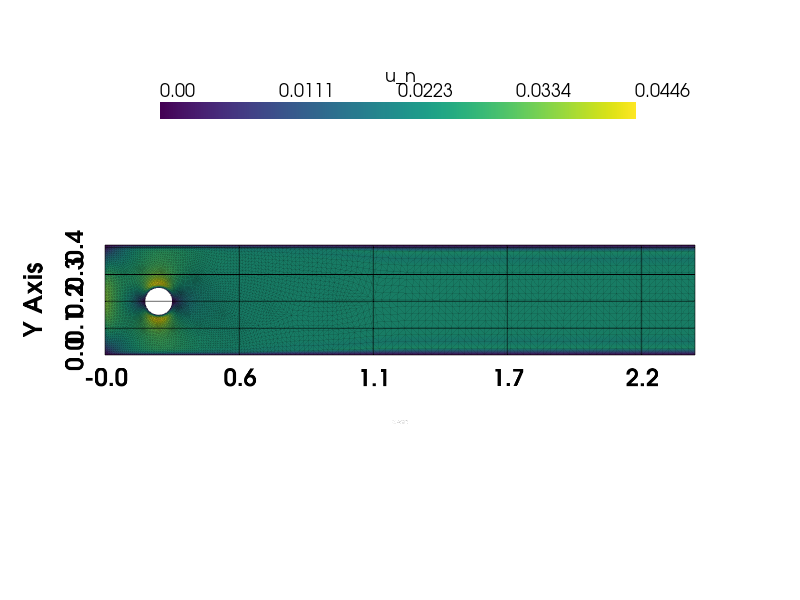

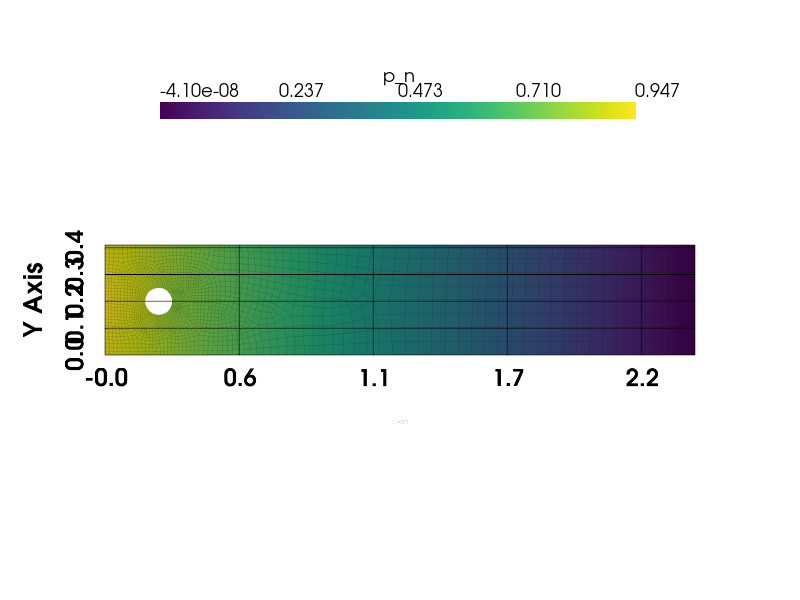

In [45]:
if interactive_mode_is_on:
    library.plot.contour_plot(u_n, geometry_dim=2)
    library.plot.contour_plot(p_n, geometry_dim=2)

### **Student TODO**: Simulate the Karman vortex street

Finally, we run the transient simulation for a longer time to observe
the vortex street behind the cylinder.

This will take a while, so on the cluster you will have to run the
notebook as a batch job.

If all the tests above pass, run the notebook on the cluster with the
command

    sbatch < library/batch_hw03.sh

**Note:** You can try running on the frontend with
`apptainer run dolfinx_latest.sif homework03.out.ipynb` but note your
simulation might then get killed by the scheduler due to the long
runtime.

In [46]:
# Final time
T_final = 8
# Timestep size
dt.value = 1 / 2000
num_steps = int(T_final / dt.value)

inlet_velocity_transient = InletVelocityTransient(U_max_transient, t)

if transient_test_passed:
    solve_time_loop("cylinder_navier_stokes_vortex_street", weak_form_navier_stokes_transient_lhs, weak_form_navier_stokes_transient_rhs, boundary_conditions_cylinder_flow, inlet_velocity_transient, num_steps, write_solution_every_n_steps = 30)
else: 
    print_rank0("The vortex street simulation takes some time to run, so we skip it if the previous test failed. Please fix the code to make the test pass and then run the simulation again.")

Starting time loop for simulation: cylinder_navier_stokes_vortex_street


Solving PDE:   0%|          | 0/16000 [00:00<?, ?it/s]

KeyboardInterrupt: 

You can enjoy the Vortex street by opening resulting `.pvd` files in the
result `cylinder_navier_stokes_vortex_street` folder with Paraview.

Ultimately, we can compare the results of the transient simulation with
benchmark results from literature:

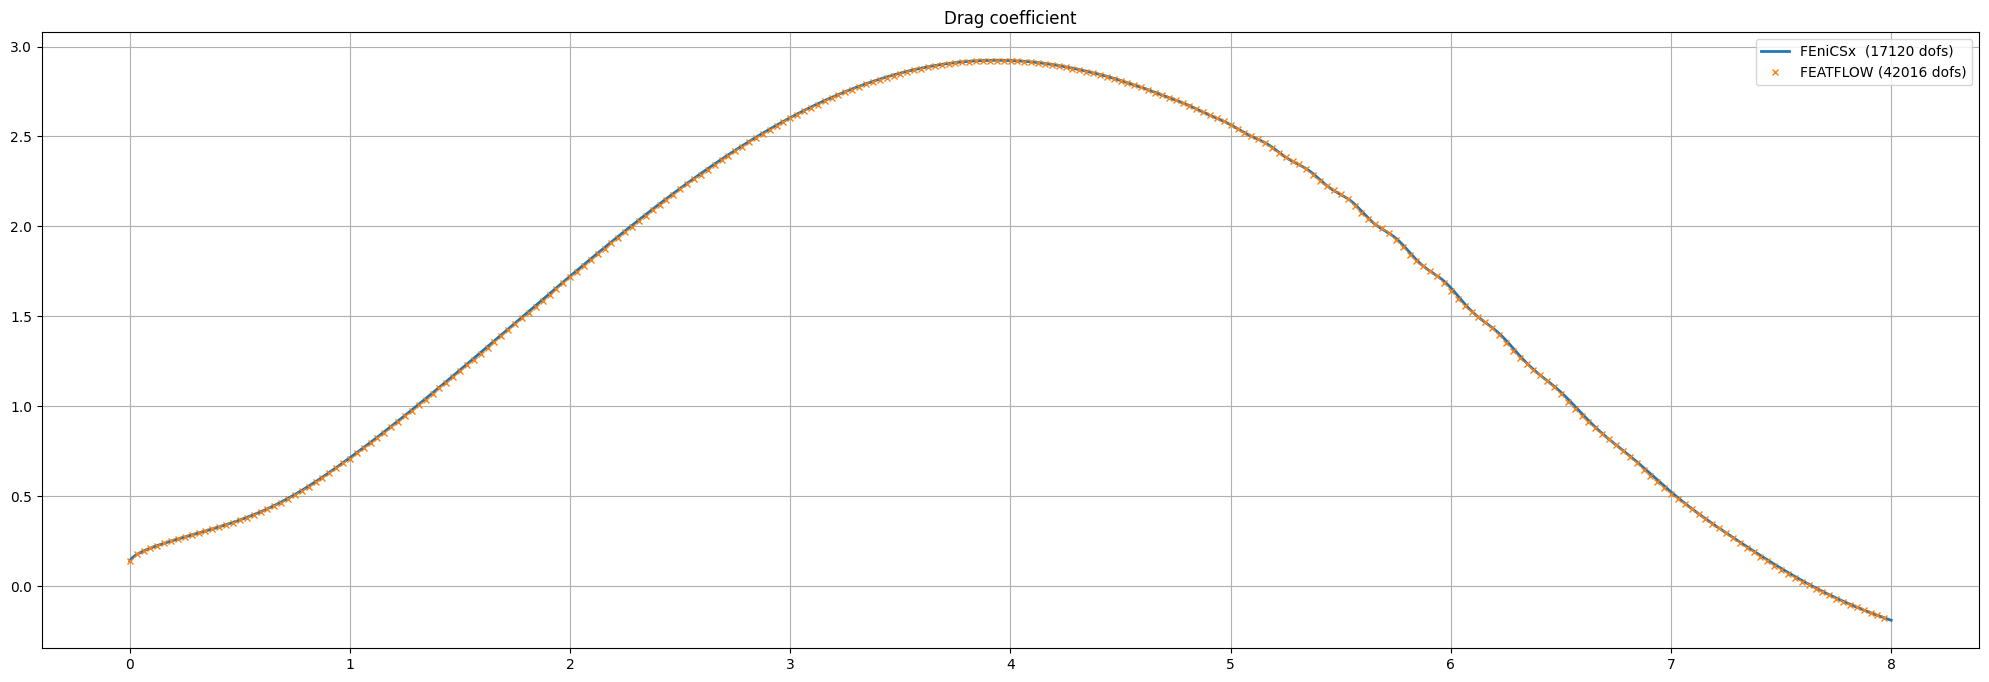

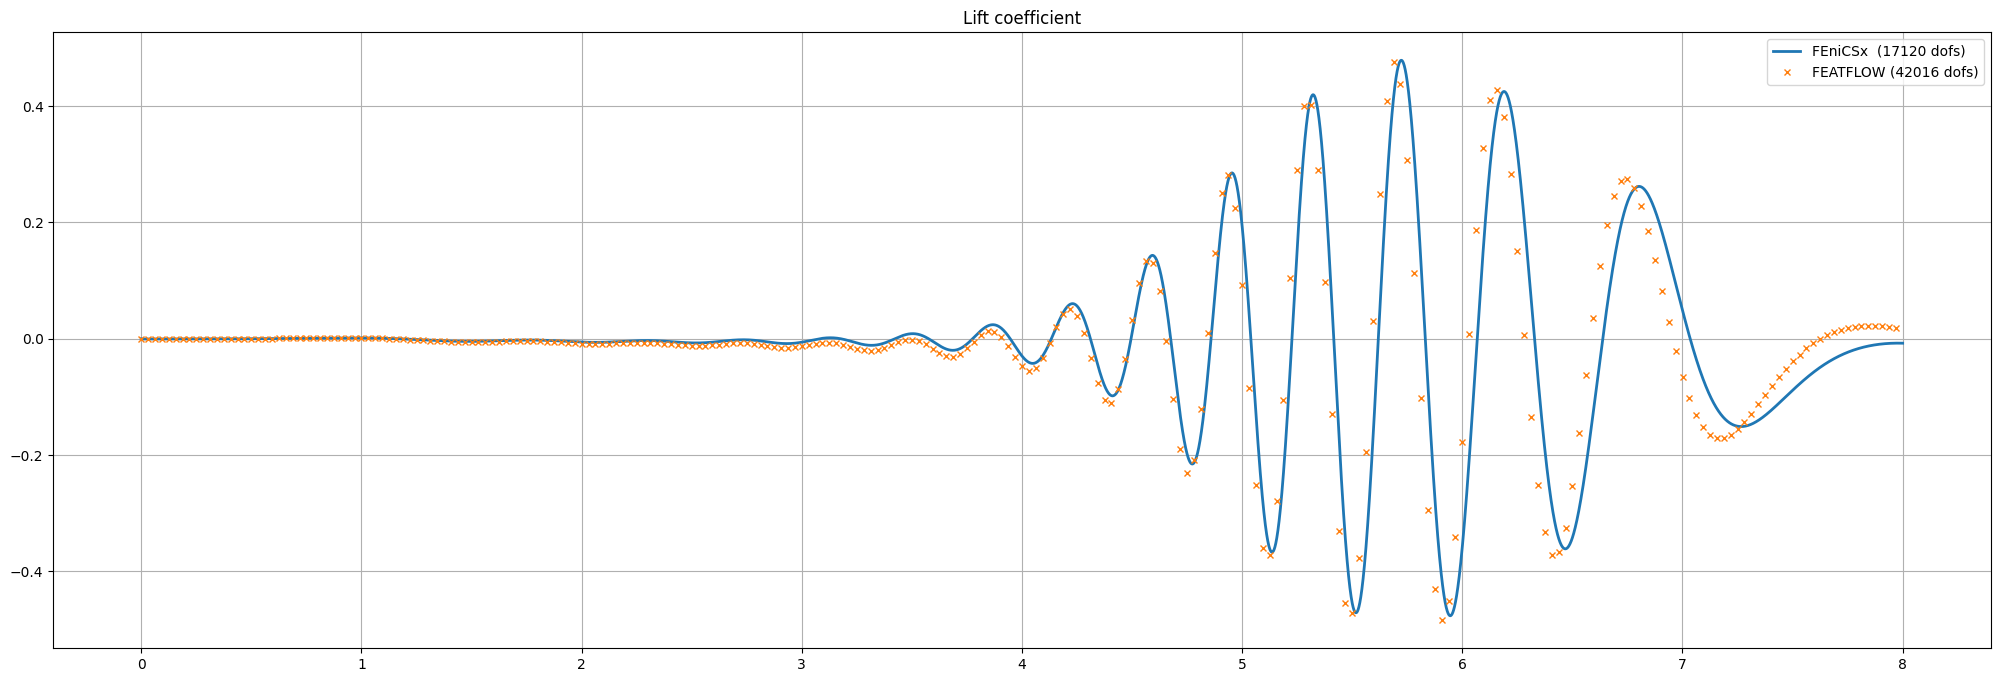

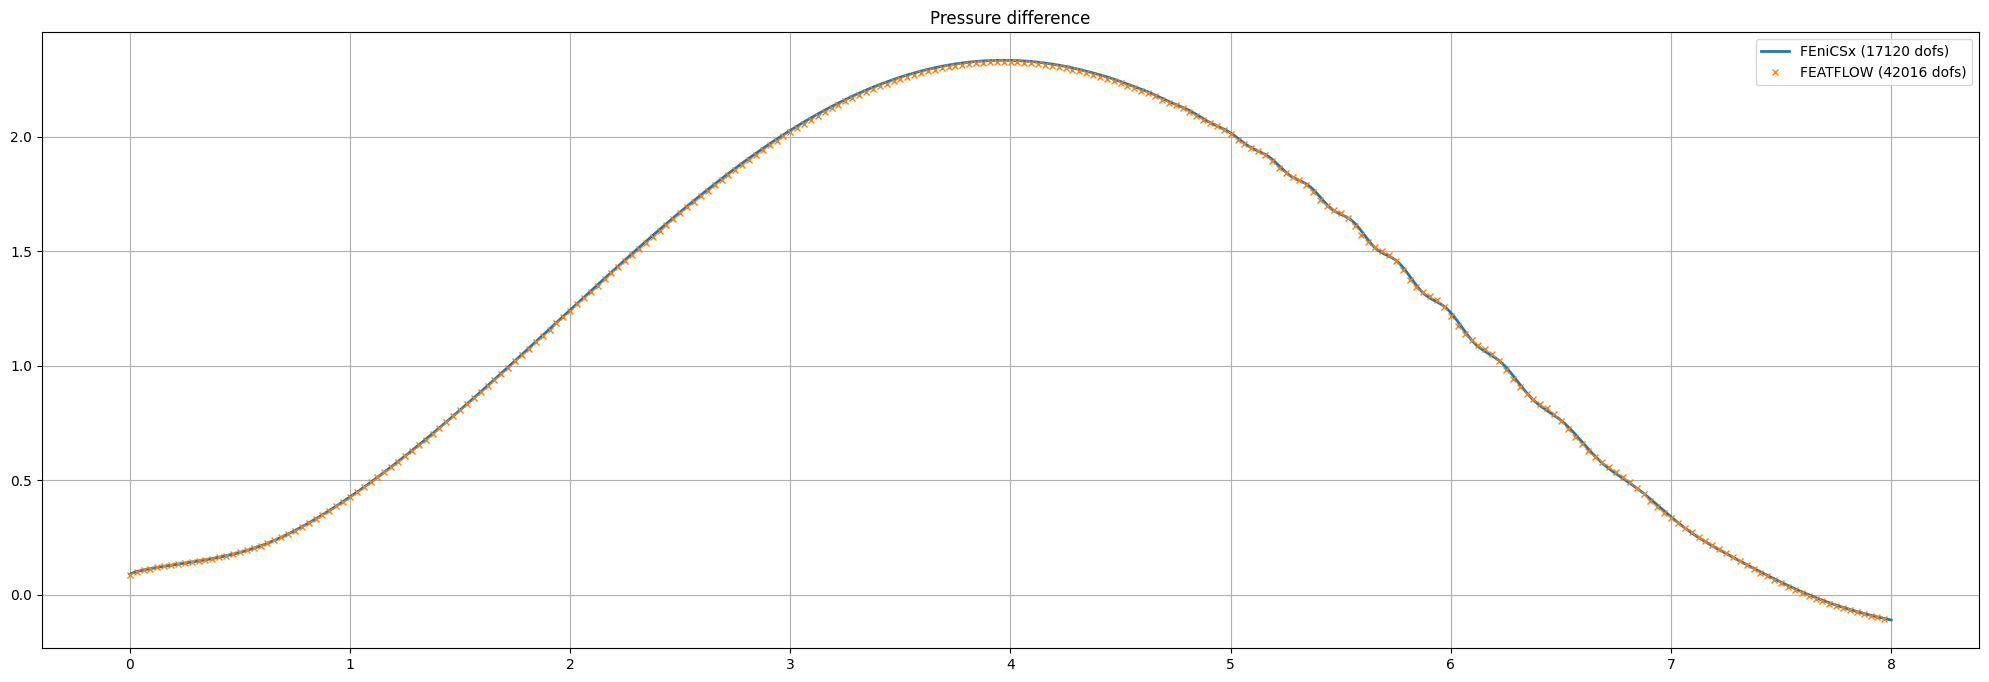

In [54]:
import matplotlib.pyplot as plt

folder_abs_path = os.path.abspath("")
reference_folder = Path(folder_abs_path + "/library/data_hw03/reference_values_cylinder")
reference_folder.mkdir(exist_ok=True, parents=True)

figure_folder = Path(output_dir + "/results_validation_cylinder")
figure_folder.mkdir(exist_ok=True, parents=True)

if mesh.comm.rank == 0:
    num_dofs = W.dofmap.index_map_bs * W.dofmap.index_map.size_global

    turek = np.loadtxt(reference_folder / "bdforces_lv4")
    turek_p = np.loadtxt(reference_folder / "pointvalues_lv4")
    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(
        t_u,
        C_D,
        label=r"FEniCSx  ({0:d} dofs)".format(num_dofs),
        linewidth=2,
    )
    l2 = plt.plot(
        turek[1:, 1],
        turek[1:, 3],
        marker="x",
        markevery=50,
        linestyle="",
        markersize=4,
        label="FEATFLOW (42016 dofs)",
    )
    plt.title("Drag coefficient")
    plt.grid()
    plt.legend()
    plt.savefig(figure_folder / "drag_comparison.png")

    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(
        t_u,
        C_L,
        label=r"FEniCSx  ({0:d} dofs)".format(num_dofs),
        linewidth=2,
    )
    l2 = plt.plot(
        turek[1:, 1],
        turek[1:, 4],
        marker="x",
        markevery=50,
        linestyle="",
        markersize=4,
        label="FEATFLOW (42016 dofs)",
    )
    plt.title("Lift coefficient")
    plt.grid()
    plt.legend()
    plt.savefig(figure_folder / "lift_comparison.png")

    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(
        t_p,
        p_diff,
        label=r"FEniCSx ({0:d} dofs)".format(num_dofs),
        linewidth=2,
    )
    l2 = plt.plot(
        turek[1:, 1],
        turek_p[1:, 6] - turek_p[1:, -1],
        marker="x",
        markevery=50,
        linestyle="",
        markersize=4,
        label="FEATFLOW (42016 dofs)",
    )
    plt.title("Pressure difference")
    plt.grid()
    plt.legend()
    plt.savefig(figure_folder / "pressure_comparison.png")

Visualize the results and check that your results match the reference
plots.

Your result:


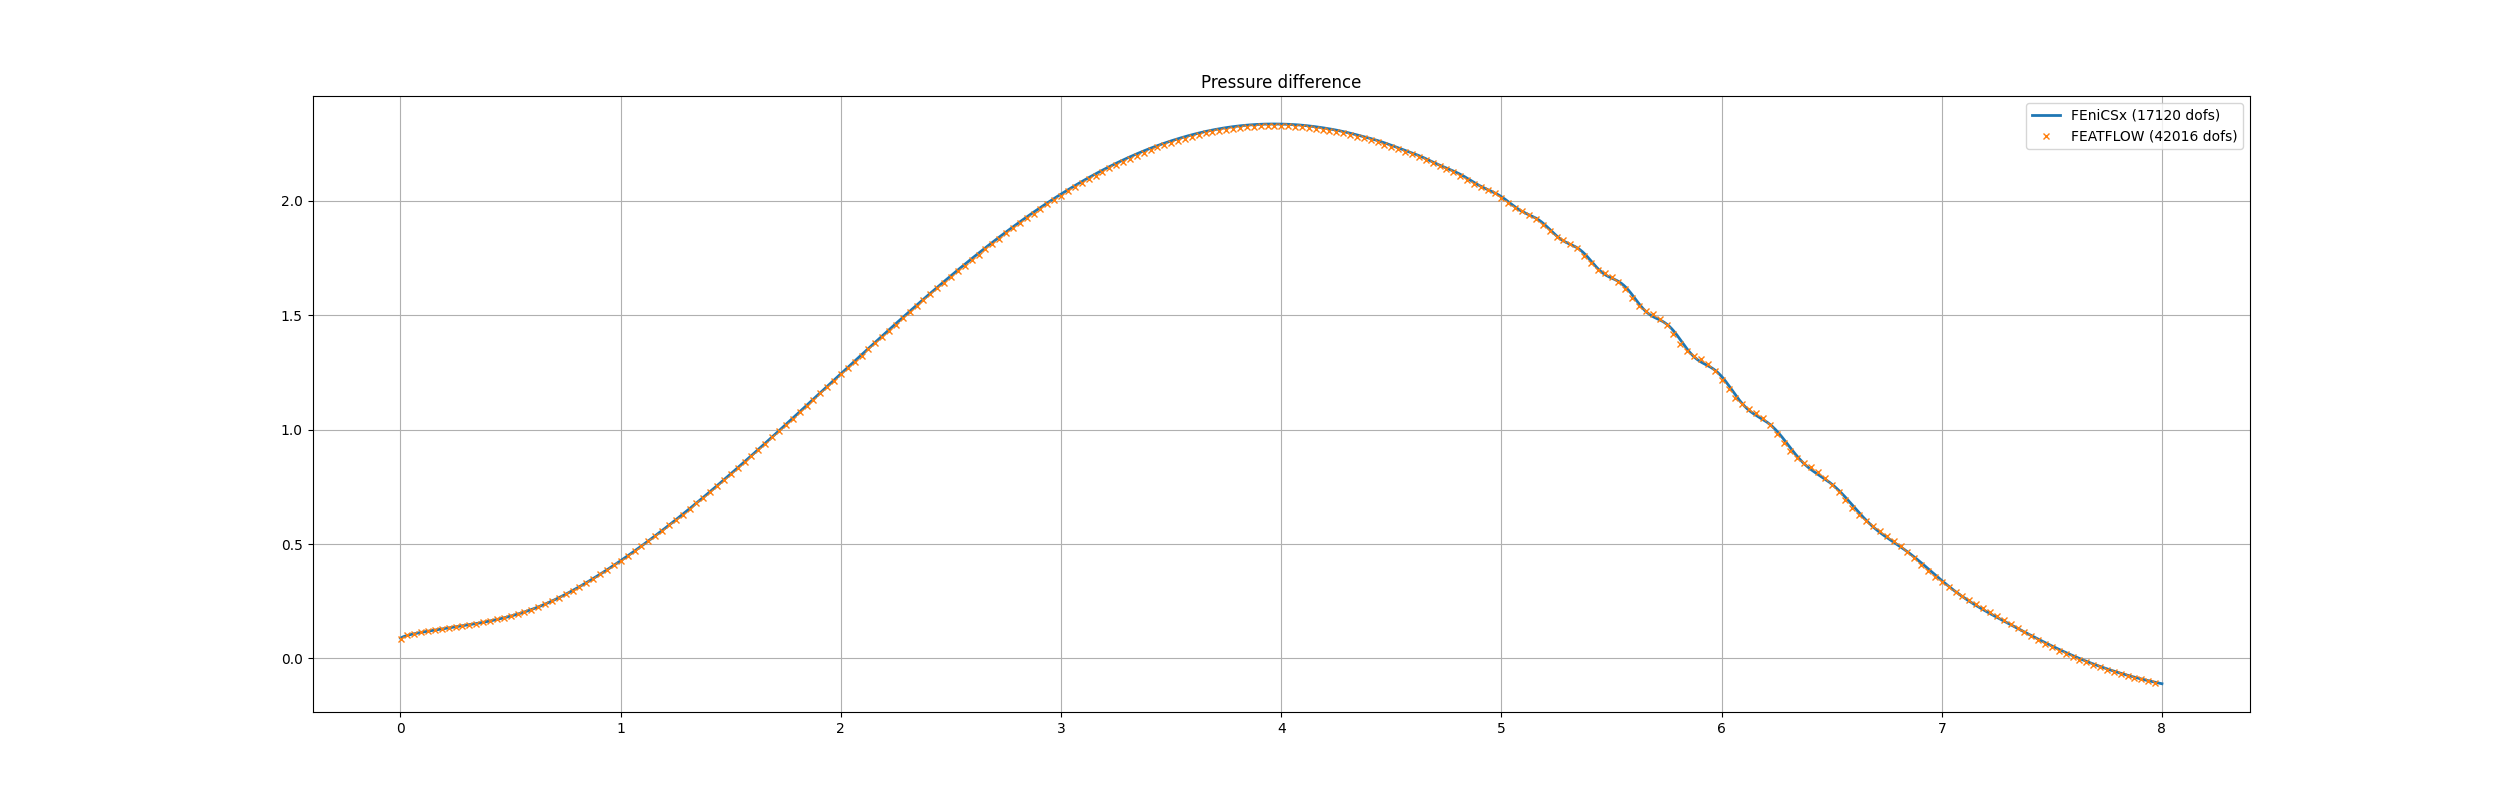

In [48]:
library.plot.display_image(image_path=os.path.join(figure_folder, 'pressure_comparison.png'))


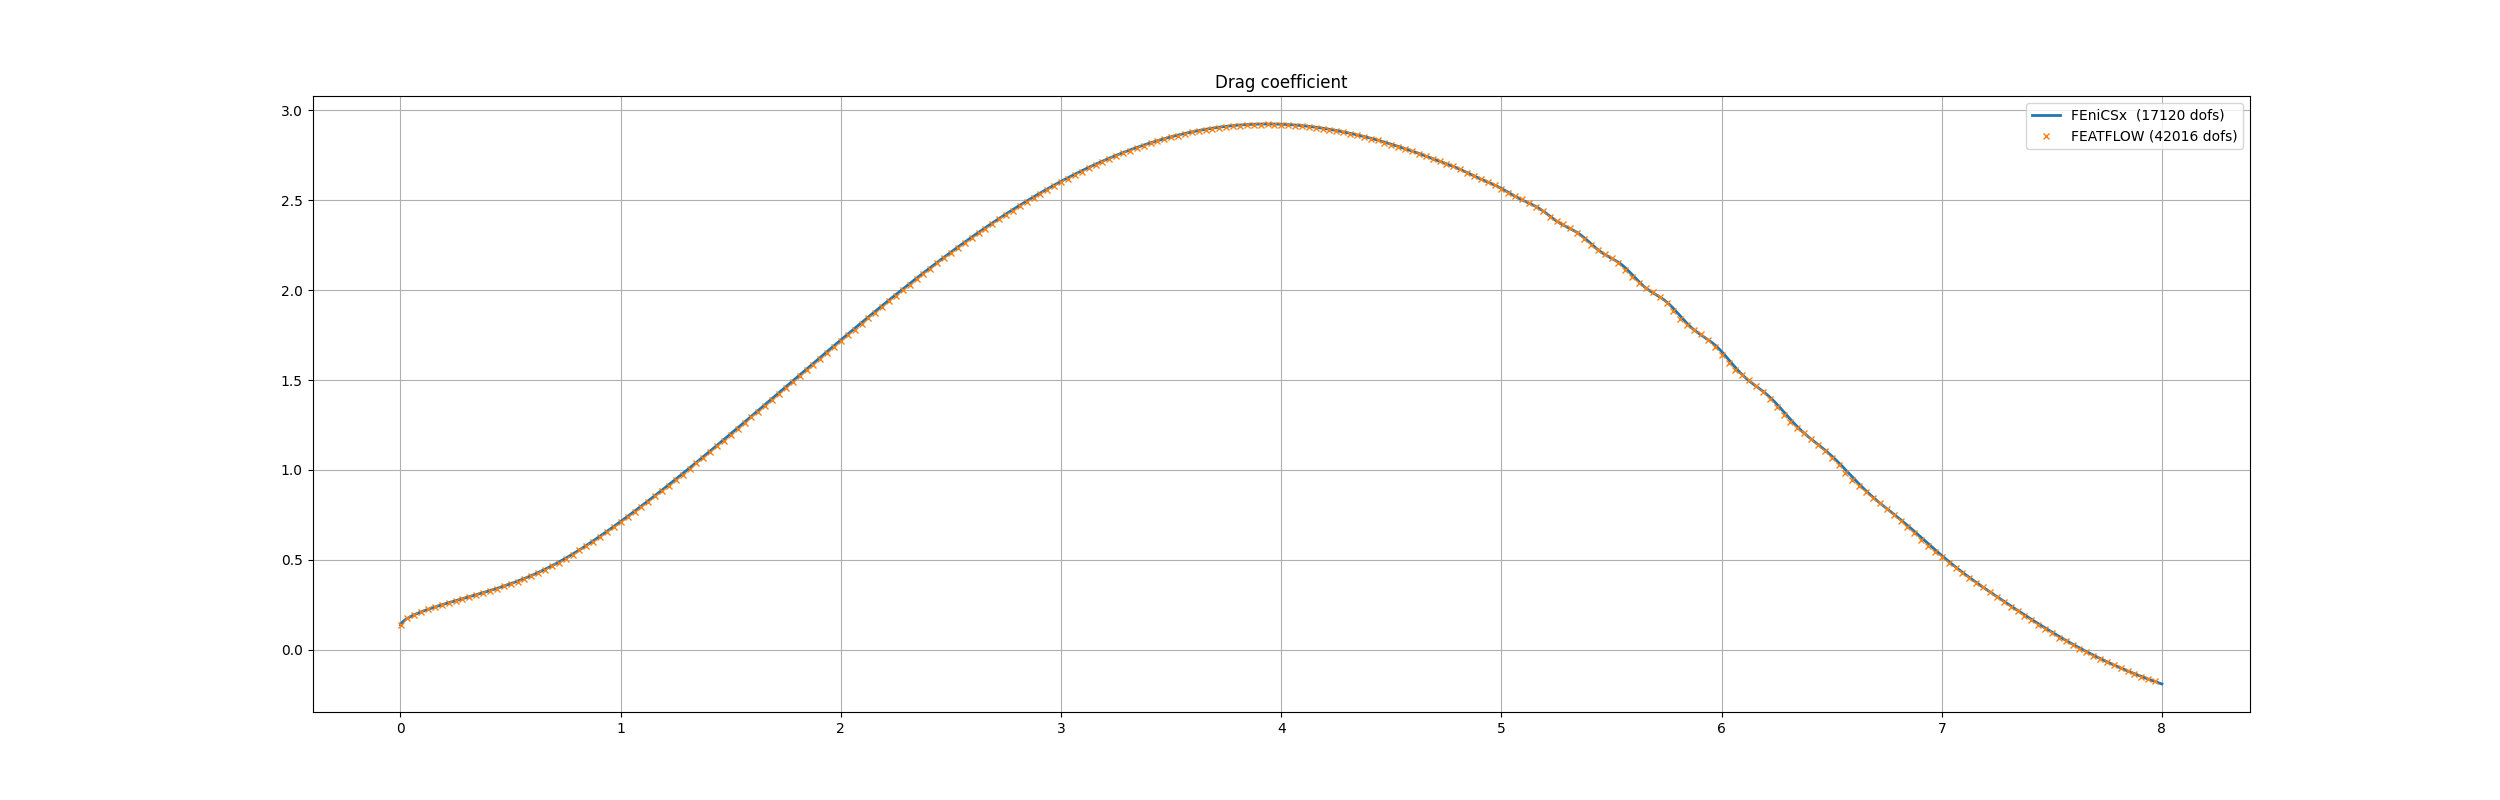

In [49]:
library.plot.display_image(image_path=os.path.join(figure_folder, 'drag_comparison.png'))


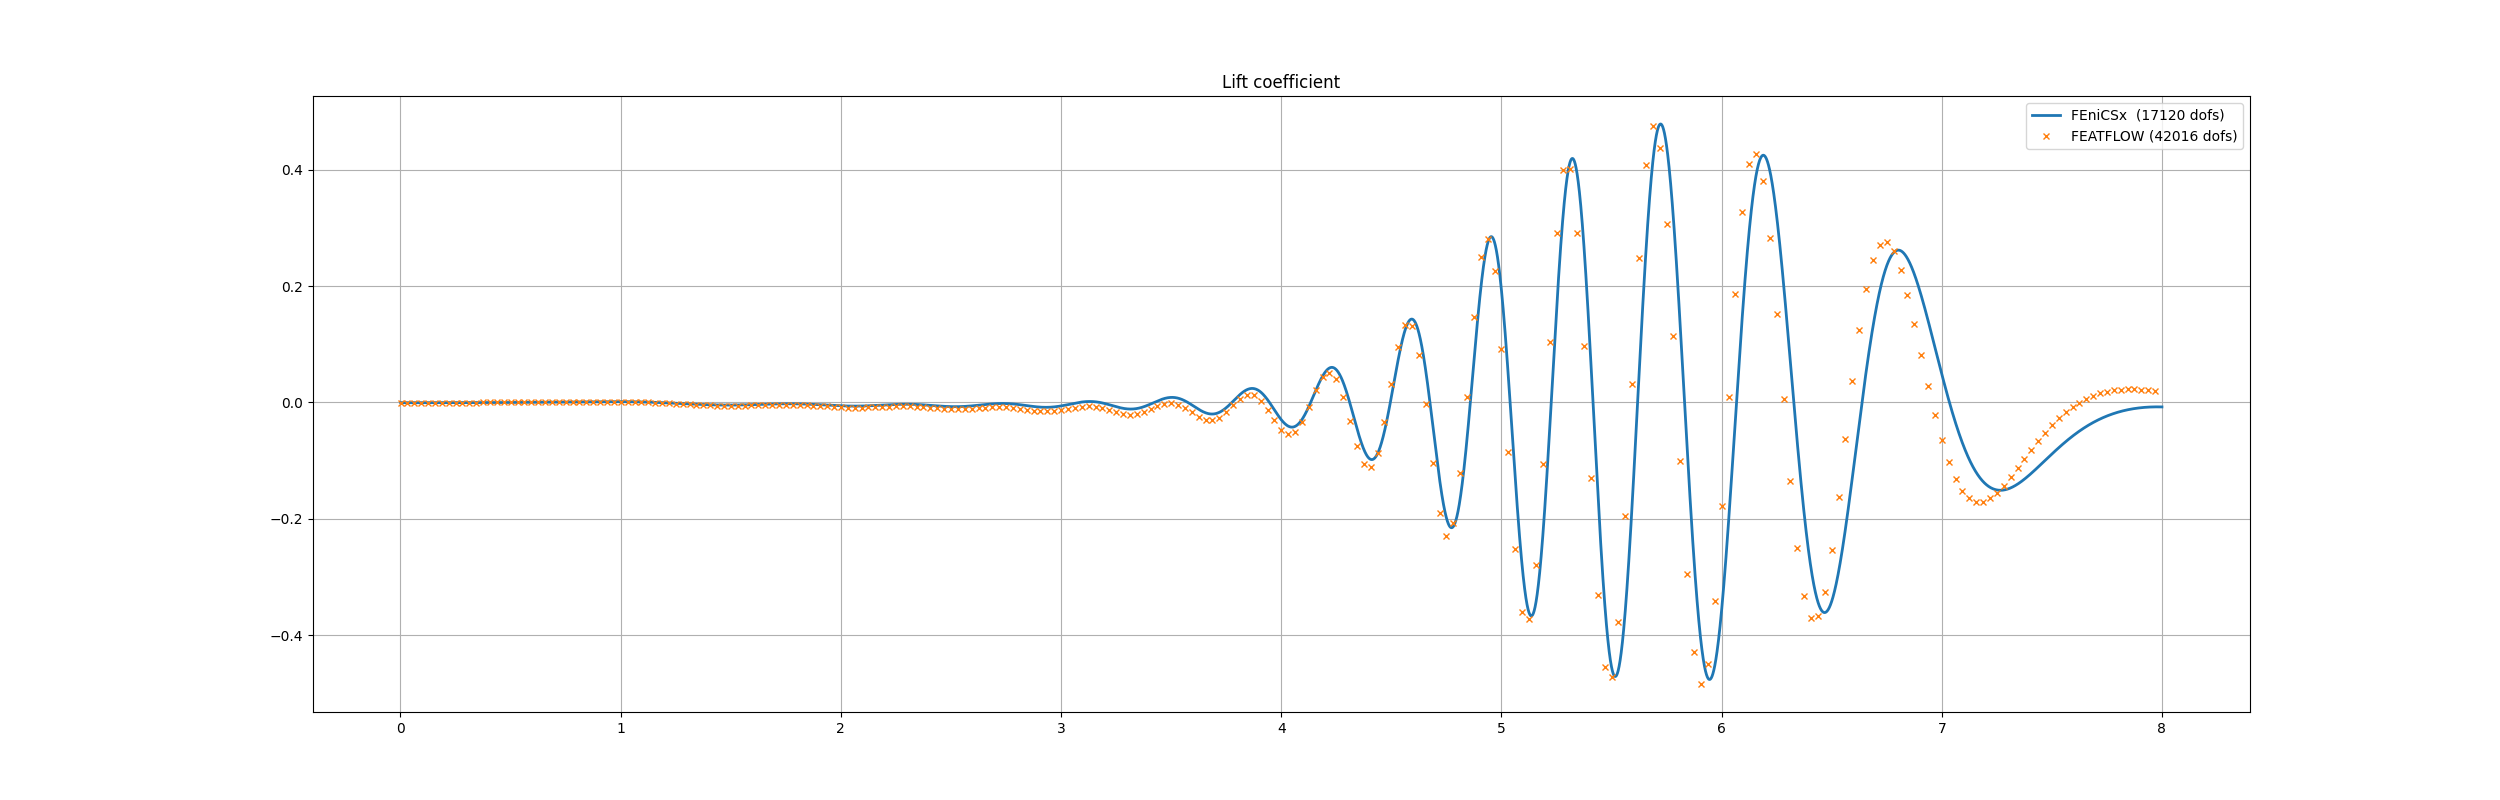

In [50]:
library.plot.display_image(image_path=os.path.join(figure_folder, 'lift_comparison.png'))

Reference plots:


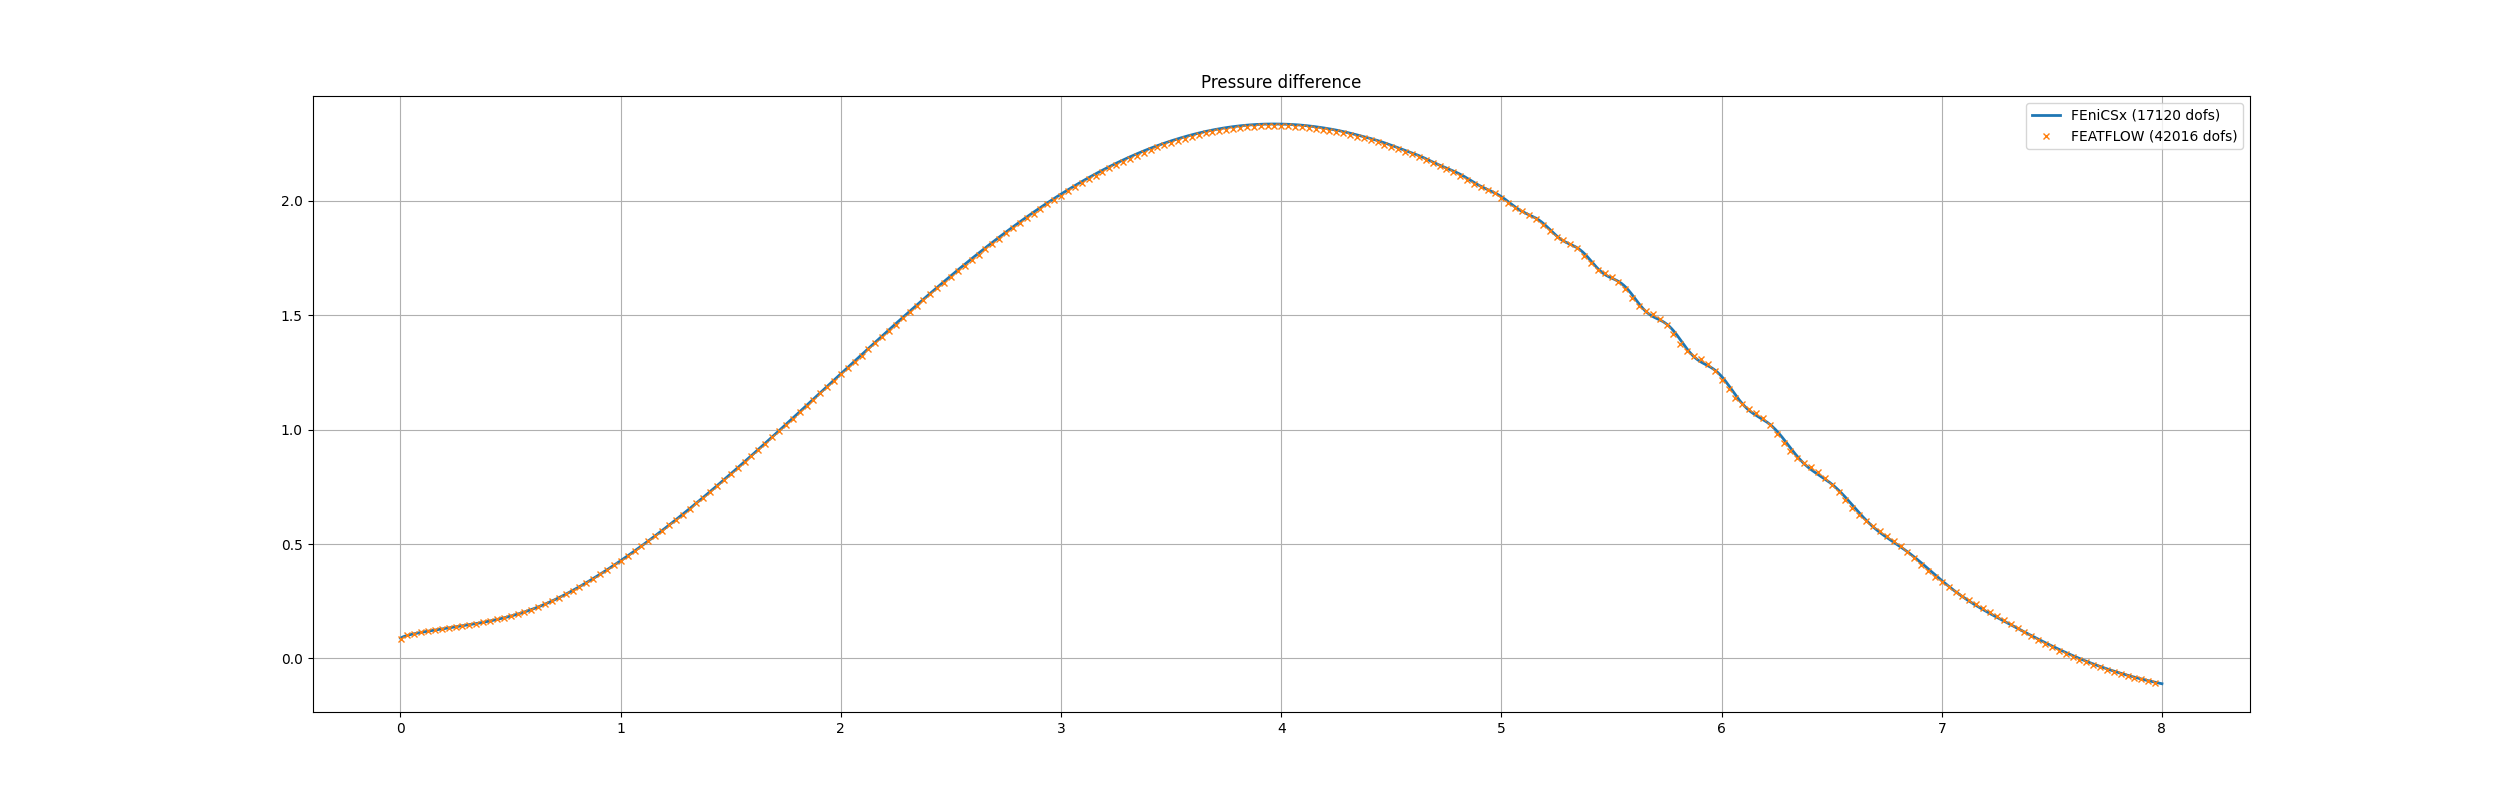

In [51]:
library.plot.display_image(image_path=os.path.join(reference_folder, 'pressure_comparison_reference.png'))


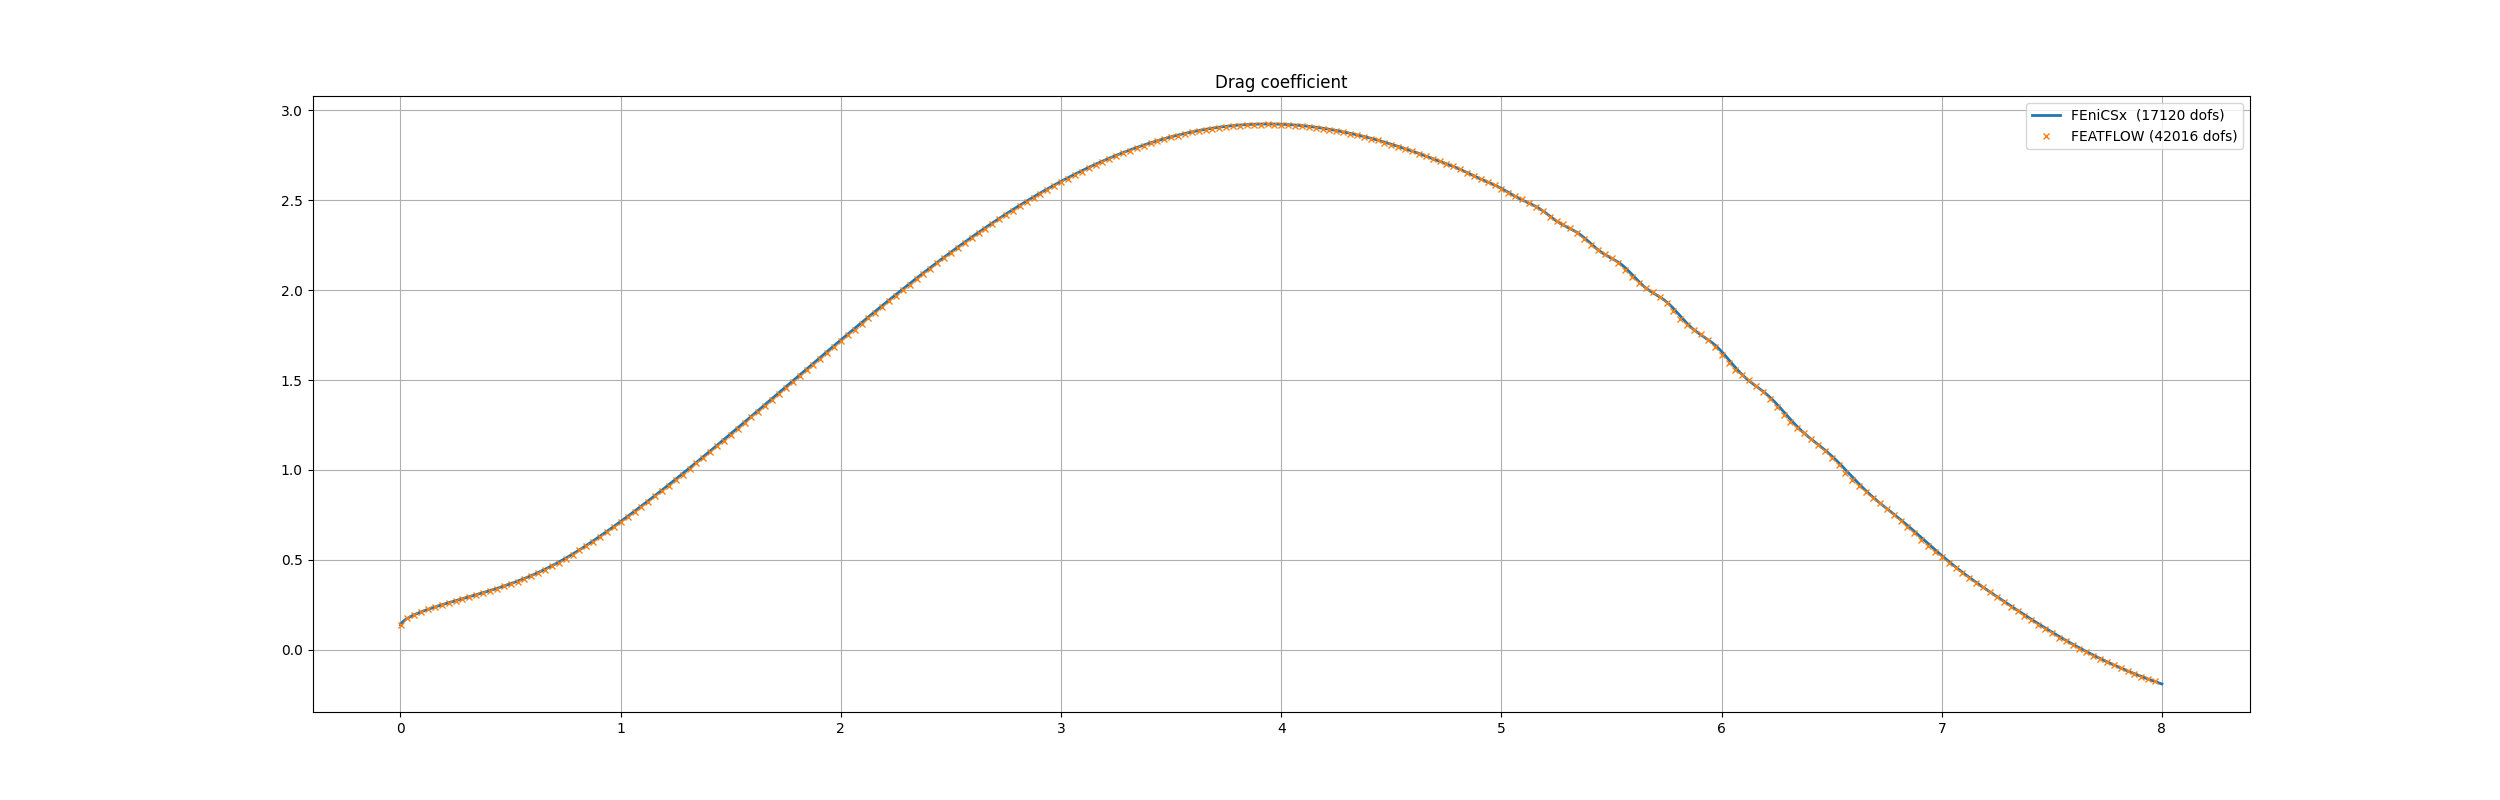

In [52]:
library.plot.display_image(image_path=os.path.join(reference_folder, 'drag_comparison_reference.png'))


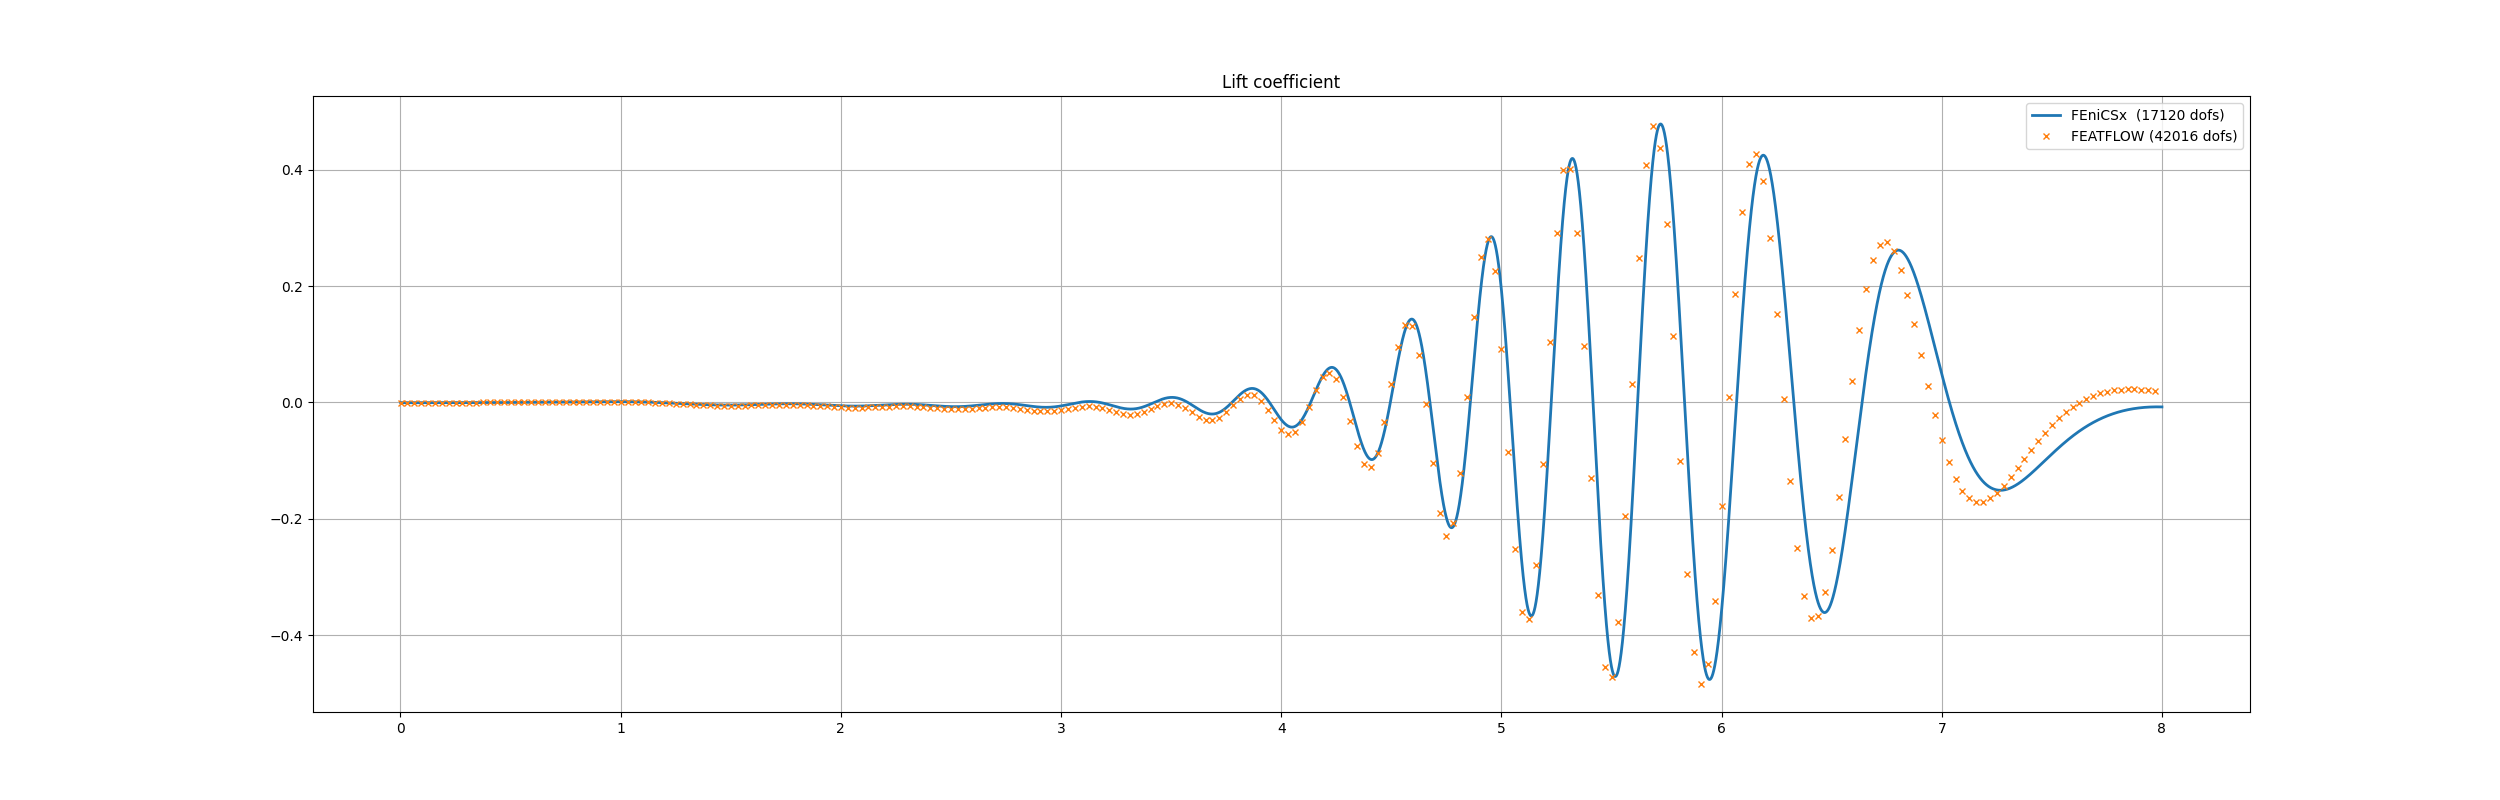

In [53]:
library.plot.display_image(image_path=os.path.join(reference_folder, 'lift_comparison_reference.png'))

# Prepare for your presentation

During the presentation, be prepared to answer the following
questions/tasks. We will ask 1-2 questions per person.

-   What was the exercise about? Give a short summary and name the tasks
    that you had to solve.
-   Sketch the setup of the Couette flow problem, and give the
    analytical solution.
-   Write down the stationary Stokes equation of an incompressible
    fluid, and explain the meaning of the terms.
-   How are the Navier-Stokes equations related to the Stokes equations?
-   How can we express this in terms of the Reynolds number?
-   Name one complication in solving the Navier-Stokes equations
    numerically as compared to the Stokes equations.
-   Sketch the Cylinder flow domain and inflow velocity profile.